## A Library for Trajectory Data

Reference: Repository of [Learning Force Fields from Stochastic Trajectories, Anna Frishman and Pierre Ronceray, Phys. Rev. X 10, 021009, 2020](https://github.com/ronceray/StochasticForceInference)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, qr, LinAlgError
from scipy.constants import Boltzmann as kB
from math import pi

class StochasticTrajectoryData(object):
    """This class is a formatter and wrapper class for stochastic
    trajectories. It performs basic operations (discrete derivative,
    mid-point "Stratonovich" positions), and provides plotting
    functions for the trajectory and inferred force and diffusion
    fields (2D with matplotlib, 3D with mayavi2).

    """ 
    def __init__(self,data,t,data_type='homogeneous'):
        """If data_type is 'homogeneous', data is a list of length Nsteps of
        Nparticles x d numpy arrays, where d is the dimensionality of
        phase space, Nsteps the length of the trajectory, and
        Nparticles the number of particles (assumed identical).

        If it is 'heterogeneous', this corresponds to trajectories
        where the number of particles varies with time, for
        instance. In this case we'll assume that the analysis has been
        done before, and that data is a dictionary with keys dX_plus,
        dX_minus, X_ito, X_strat and dt. For each time point the
        arrays dX, X_ito and X_strat must have the same dimensions.

        dX_plus  = X(t+dt)-X(t)
        dX_minus = X(t)-X(t-dt)

        """
        if data_type == 'homogeneous':
            Nparticles,self.d = data[0].shape
            self.t = t[1:-1]
            self.dt = t[2:] - t[1:-1] 

            self.X_ito = 1. * data[1:-1] 
            self.dX_plus = data[2:] - data[1:-1]
            self.dX_minus = data[1:-1] - data[:-2]
            self.X_strat = self.X_ito + 0.5 * self.dX_plus
            self.Xdot = np.einsum('tmi,t->tmi',self.dX_plus, 1. /self.dt)
            self.Nparticles = [ X.shape[0] for X in self.X_strat ] 
            # Total time-per-particle in the trajectory
            self.tauN = np.einsum('t,t->',self.dt,self.Nparticles)


        elif data_type == 'heterogeneous':
            self.t = t
            self.X_ito = data['X_ito']
            self.dX_plus  = data['dX_plus']
            self.dX_minus = data['dX_minus']
            self.dt = data['dt']
            self.X_strat = [ self.X_ito[t] + 0.5 * self.dX_plus[t] for t,dt in enumerate(self.dt) ]
            self.d = self.X_ito[0].shape[1]
            self.Nparticles = [ X.shape[0] for X in self.X_strat ] 
            self.tauN = np.einsum('t,t->',self.dt,self.Nparticles)
            self.Xdot = [  self.dX_plus[t] / dt for t,dt in enumerate(self.dt) ]
            
        else:
            raise KeyError("Wrong data_type")

    def inner_product_empirical(self,f,g,integration_style='Stratonovich'):
        # Time integration of two functions (with indices) of the
        # position along the trajectory, with averaging over particle
        # indices.

        # Two ways of calling it (can be mixed):
        #  - with an array (t-1) x Nparticles x dim (eg for Xdot)
        
        #  - with a dxN-dimensional callable function f(X) (eg for the
        #    moments); will apply it on all time-points and particles,
        #    with corresponding arguments.
        if integration_style=='Stratonovich':
            X = self.X_strat
            dt = self.dt
        elif integration_style=='Ito':
            X = self.X_ito
            dt = self.dt
        elif integration_style=='smooth':
            X = [ self.X_ito[t] + (self.dX_plus[t]-self.dX_minus[t])/3. for t,dt in enumerate(self.dt) ]
            dt = self.dt
        elif integration_style=='Isothermal': # aka Hanggi or anti-Ito
            X = [ self.X_ito[t] + self.dX_plus[t] for t,dt in enumerate(self.dt) ]
            dt = self.dt
        else:
            raise KeyError("Wrong integration_style keyword.")
        func = lambda t : np.einsum('im,in->mn', f(X[t]) if callable(f) else f[t] , g(X[t]) if callable(g) else g[t] )
        return self.trajectory_integral(func,dt)

    def trajectory_integral(self,func,dt=None):
        # A helper function to perform trajectory integrals with
        # constant memory use. The function takes integers as
        # argument.
        if dt is None:
            dt = self.dt
        result = 0. # Generic initialization - works with any
                    # array-like function.
        for t,ddt in enumerate(dt):
            result += ddt * func(t)
        return result / self.tauN

    
    def plot_process(self,dir1=None,dir2=None,shift=(0,0),tmin=None,tmax=None, particle=0,dx_pre_too=False,**kwargs):
        """Basic 2D plotting of the trajectory. The color gradient indicates
        time. dir1 and dir2 arguments, if specified, should be two
        orthogonal unit vectors, defining the projection plane of the
        representation. 'particle' argument indicates which particle
        should be considered, if relevant.
        """
        if dir1 is None:
            dir1 = axisvector(0,self.d)
        if dir2 is None:
            dir2 = axisvector(1,self.d)
        x = np.array([ dir1.dot(u[particle,:]) for u in self.X_ito[tmin:tmax] ])
        y = np.array([ dir2.dot(u[particle,:]) for u in self.X_ito[tmin:tmax] ])
        dx = np.array([ dir1.dot(u[particle,:]) for u in self.dX_plus[tmin:tmax] ])
        dy = np.array([ dir2.dot(u[particle,:]) for u in self.dX_plus[tmin:tmax] ])
        plt.quiver(x+shift[0],y+shift[1],dx,dy,self.t[tmin:tmax],
                   headaxislength = 0.0,headwidth = 0., headlength = 0.0, minlength=0., minshaft = 0.,  scale = 1.0,units = 'xy',lw=0.,**kwargs)
        if dx_pre_too:
            dxp = np.array([ dir1.dot(u[particle,:]) for u in self.dX_minus[tmin:tmax] ])
            dyp = np.array([ dir2.dot(u[particle,:]) for u in self.dX_minus[tmin:tmax] ])
            plt.quiver(x+shift[0],y+shift[1],-dxp,-dyp,self.t[tmin:tmax][:-1] ,
                   headaxislength = 0.0,headwidth = 0., headlength = 0.0, minlength=0., minshaft = 0.,  scale = 1.0,units = 'xy',lw=0.,**kwargs)
        plt.axis('equal') 
        plt.xticks([])
        plt.yticks([])
    

    def plot_field(self,dir1=None,dir2=None,field=None,center=None,N = 10,scale=1.,autoscale=False,color='g',radius=None,positions = None,**kwargs):
        """Plot a 2D vector field (or a 2D slice of a higher-dimensional
        field), either as a mesh or on a specified list of points. The
        'field' parameter is a lambda function X -> F(X), for instance.
        """
        if dir1 is None:
            dir1 = axisvector(0,self.d)
        if dir2 is None:
            dir2 = axisvector(1,self.d)
        if center is None:
            center = self.X_ito.mean(axis=(0,1))
        if radius is None:
            radius  = 0.5 * ( self.X_ito.max(axis=(0,1)) - self.X_ito.min(axis=(0,1)) ).max()

        if positions is None:
            positions = []
            for a in np.linspace(-radius,radius,N):
                for b in np.linspace(-radius,radius,N):
                    positions.append(center + a * dir1 + b * dir2 )

        gridX,gridY = [],[]
        vX,vY = [],[]
        for pos in positions:
            x = dir1.dot(pos)
            y = dir2.dot(pos)
            gridX.append(x)
            gridY.append(y)
            # Reshape to adapt to the SFI data structure (1st index is
            # particle index):
            v = field( pos.reshape((1,self.d)) )
            vX.append(dir1.dot(v[0,:]))
            vY.append(dir2.dot(v[0,:]))

        if autoscale:
            scale /= max(np.array(vX)**2 + np.array(vY)**2)**0.5
        plt.quiver(gridX,gridY,scale*np.array(vX),scale*np.array(vY) ,scale = 1.0,units = 'xy',color = color,minlength=0.,**kwargs)
        plt.ylim(-radius+dir2.dot(center),radius+dir2.dot(center))
        plt.xlim(-radius+dir1.dot(center),radius+dir1.dot(center))
        plt.axis('equal') 
        plt.xticks([])
        plt.yticks([])


    def plot_tensor_field(self,field,center=None,N = 10,scale=1.,autoscale=False,color='g',radius=None,positions=None,**kwargs):
        """ Plot a tensor field for 2D processes. """
        if center is None:
            center = self.X_ito.mean(axis=(0,1))
        if radius is None:
            radius  = 0.5 * ( self.X_ito.max(axis=(0,1)) - self.X_ito.min(axis=(0,1)) ).max()

        if positions is None:
            positions = []
            for a in np.linspace(-radius,radius,N):
                for b in np.linspace(-radius,radius,N):
                    positions.append(center + np.array([a,b]))

        X,Y,U,V = [],[],[],[]
        for pos in positions: 
            posr = pos.reshape((1,self.d)) 
            tensor = field( posr )
            eigvals,eigvecs = np.linalg.eigh(tensor.reshape((2,2)))
            for j in range(2): 
                X.append( pos[0] )
                Y.append( pos[1] )
                U.append( eigvals[j] * eigvecs[0,j] )
                V.append( eigvals[j] * eigvecs[1,j] )

        if autoscale:
            scale /= max(np.array(U)**2 + np.array(V)**2)**0.5

        X,Y =  np.array(X),np.array(Y)
        dX,dY = 0.5*scale*np.array(U),0.5*scale*np.array(V)
                                            
        plt.quiver(X-dX,Y-dY,2*dX,2*dY,scale = 1.0,units = 'xy',color = color,minlength=0.,headwidth=1.,headlength=0.,**kwargs)
                                                 
        plt.axis('equal') 
        plt.xticks([])
        plt.yticks([])


    def plot_process_3D(self,dir1=None,dir2=None,dir3=None,clear=False,particle=0):
        """3D visualization of the trajectory using Mayavi; shading indicates
        time."""
        if dir1 is None:
            dir1 = axisvector(0,self.d)
        if dir2 is None:
            dir2 = axisvector(1,self.d)
        if dir3 is None:
            dir3 = axisvector(2,self.d)
        import mayavi.mlab
        if clear:
            mayavi.mlab.clf()
        f = mayavi.mlab.gcf()
        f.scene.background = (1.,1.,1.)
        x = np.array([ dir1.dot(u[particle,:]) for u in self.X_ito ])
        y = np.array([ dir2.dot(u[particle,:]) for u in self.X_ito ])
        z = np.array([ dir3.dot(u[particle,:]) for u in self.X_ito ])
        mayavi.mlab.plot3d(x,y,z,self.t,colormap='bone')


    def plot_field_3D(self,field,dir1=None,dir2=None,dir3=None,center=None,Npts = 10,scale=1.,autoscale=False,color='g',radius=None,positions = None,cmap='summer',cval=0.,**kwargs):
        # Display a 3D vector field (requires Mayavi2 package)
        import mayavi.mlab
        f = mayavi.mlab.gcf()
        f.scene.background = (1.,1.,1.)

        if dir1 is None:
            dir1 = axisvector(0,self.d)
        if dir2 is None:
            dir2 = axisvector(1,self.d)
        if dir3 is None:
            dir3 = axisvector(2,self.d)
        if center is None:
            center = self.X_ito.mean(axis=(0,1))
        if radius is None:
            radius  = 0.5 * ( self.X_ito.max(axis=(0,1)) - self.X_ito.min(axis=(0,1)) ).max()

        if positions is None:
            positions = []
            for a in np.linspace(-radius,radius,Npts):
                for b in np.linspace(-radius,radius,Npts):
                    for c in np.linspace(-radius,radius,Npts):
                        positions.append(center + a * dir1 + b * dir2 + c * dir3 )

        gridX,gridY,gridZ = [],[],[]
        vX,vY,vZ = [],[],[]
        for pos in positions:
            x = dir1.dot(pos)
            y = dir2.dot(pos)
            z = dir3.dot(pos)
            gridX.append(x)
            gridY.append(y)
            gridZ.append(z)
            # Reshape to adapt to the SFI data structure (1st index is
            # particle index):
            v = field( pos.reshape((1,self.d)) )
            vX.append(dir1.dot(v[0,:]))
            vY.append(dir2.dot(v[0,:]))
            vZ.append(dir3.dot(v[0,:]))

        if autoscale:
            scale /= max(np.array(vX)**2 + np.array(vY)**2 + np.array(vZ)**2)**0.5
            #print("Vector field scale:",scale)
        
        mayavi.mlab.quiver3d(gridX,gridY,gridZ,scale*np.array(vX),scale*np.array(vY),scale*np.array(vZ),scalars=0.*np.array(vZ)+cval,vmin=0.,vmax=1.,colormap=cmap,mode='arrow', scale_factor = 2.,scale_mode = 'vector', resolution = 8 )


    def plot_tensor_field_3D(self,field=None,center=None,Npts = 7,scale=1.,autoscale=True,color='g',radius=None,positions = None,cmap='summer',cval=0.,**kwargs):
        # Display a 3D tensor field (requires Mayavi2 package)
        import mayavi.mlab
        f = mayavi.mlab.gcf()
        f.scene.background = (1.,1.,1.)
            
        if center is None:
            center = self.X_ito.mean(axis=(0,1))
        if radius is None:
            radius  = 0.5 * ( self.X_ito.max(axis=(0,1)) - self.X_ito.min(axis=(0,1)) ).max()

        if positions is None:
            positions = []
            for a in np.linspace(-radius,radius,Npts):
                for b in np.linspace(-radius,radius,Npts):
                    for c in np.linspace(-radius,radius,Npts):
                        positions.append(center + np.array([a,b,c]))


        X,Y,Z,U,V,W = [],[],[],[],[],[]
        for pos in positions: 
            posr = pos.reshape((1,self.d)) 
            tensor = field( posr )
            eigvals,eigvecs = np.linalg.eigh(tensor.reshape((3,3)))
            for j in range(3): 
                X.append( pos[0] )
                Y.append( pos[1] )
                Z.append( pos[2] )
                U.append( eigvals[j] * eigvecs[0,j] )
                V.append( eigvals[j] * eigvecs[1,j] )
                W.append( eigvals[j] * eigvecs[2,j] )

        if autoscale:
            scale /= max(np.array(U)**2 + np.array(V)**2 + np.array(W)**2)**0.5
            print("Tensor field scale:",scale)

       
        X,Y,Z =  np.array(X),np.array(Y),np.array(Z)
        dX,dY,dZ = 0.5*scale*np.array(U),0.5*scale*np.array(V),0.5*scale*np.array(W)

        mayavi.mlab.quiver3d(X-dX,Y-dY,Z-dZ, 2*dX, 2*dY, 2*dZ,scalars=0.*np.array(Z)+cval,vmin=0.,vmax=1.,colormap=cmap,mode='2ddash', scale_factor = 1.,scale_mode = 'vector', resolution = 8 ,**kwargs)

        
    def plot_particles(self,a=0,b=1,X=None,t=-1,colored=True,active=False,u=0.35,**kwargs):
        # Display the position of all particles at time t.
        if X is None:
            X = self.X_ito[t]
        x = X[:,a]
        y = X[:,b]
        if colored:
            plt.scatter(x,y,cmap='magma',s=100,c=np.linspace(0,1,len(X)),**kwargs)
        else:
            plt.scatter(x,y,s=100,c='w',edgecolor='k',**kwargs)
        if active:
            # Show the orientations of active Brownian particles.
            xa = x + u*np.cos(X[:,2])
            ya = y + u*np.sin(X[:,2])
            plt.scatter(xa,ya,c='k',s=20,**kwargs)
            
        plt.axis('equal')  
        plt.xticks([])
        plt.yticks([])

    def plot_particles_field(self,field,X=None,t=-1,dir1=None,dir2=None,center=None,radius=None,scale=1.,autoscale=False,color='g',**kwargs):

        if dir1 is None:
            dir1 = axisvector(0,self.d)
        if dir2 is None:
            dir2 = axisvector(1,self.d)

        # Plot a 2D vector field
        if X is None:
            X = self.X_ito[t]
        F = field(X)
        if center is None: 
            center = X.mean(axis=0)
        if radius is None:
            radius  = 0.5 * ( X.max(axis=0) - X.min(axis=0) ).max()

        gridX,gridY = [],[]
        vX,vY = [],[]
        for ind,pos in enumerate(X):
            x = dir1.dot(pos)
            y = dir2.dot(pos)
            gridX.append(x)
            gridY.append(y)
            vX.append(dir1.dot(F[ind,:]))
            vY.append(dir2.dot(F[ind,:]))

        if autoscale:
            scale /= max(np.array(vX)**2 + np.array(vY)**2)**0.5
            print("Vector field scale:",scale)
        plt.quiver(gridX,gridY,scale*np.array(vX),scale*np.array(vY) ,scale = 1.0,units = 'xy',color = color,minlength=0.,**kwargs)
        plt.ylim(-radius+dir2.dot(center),radius+dir2.dot(center))
        plt.xlim(-radius+dir1.dot(center),radius+dir1.dot(center))
        plt.axis('equal') 
        plt.xticks([])
        plt.yticks([])


def axisvector(index,dim):
    """d-dimensional vector pointing in direction index."""
    return np.array([ 1. if i == index else 0. for i in range(dim)])
 



## A library of projection bases 

In [2]:
def basis_selector(basis,data):
    is_interacting = False
    if basis['type'] == 'polynomial':
        funcs = polynomial_basis(data.d,basis['order'])
    elif basis['type'] == 'Fourier':
        funcs = Fourier_basis(data.d,basis['order'],basis['center'],basis['width'])
    elif basis['type'] == 'coarse_graining':  
        funcs = coarse_graining_basis(data.d,basis['width'],basis['center'],basis['order'])
    elif basis['type'] == 'FORMA':  
        funcs = FORMA_basis(data.d,basis['width'],basis['center'],basis['order'])
    else: # Interacting particles basis
        is_interacting = True
        if basis['type'] == 'particles_pair_interaction': 
            funcs = particles_pair_interaction(data.d,basis['kernels'])
        if basis['type'] == 'particles_pair_interaction_periodic': 
            funcs = particles_pair_interaction_periodic(data.d,basis['kernels'],basis['box'])
        elif basis['type'] == 'particles_pair_interaction_scalar': 
            funcs = particles_pair_interaction_scalar(basis['kernels'])
        elif basis['type'] == 'particles_and_polynomial': 
            funcs = particles_polynomial_composite_basis(data.d,basis['order'],basis['kernels'])
        elif basis['type'] == 'self_propelled_particles': 
            funcs = self_propelled_particles_basis(basis['order'],basis['kernels'])
        elif basis['type'] == 'single_self_propelled_particle': 
            funcs = single_self_propelled_particle_basis()
        elif basis['type'] == 'custom': 
            funcs = basis['functions']
        else:
            raise KeyError("Unknown basis type.") 
    return funcs,is_interacting



def polynomial_basis(dim,order):
    # A simple polynomial basis, X -> X_mu X_nu ... up to polynomial
    # degree 'order'.
    
    # We first generate the coefficients, ie the indices mu,nu.. of
    # the polynomials, in a non-redundant way. We start with the
    # constant polynomial (empty list of coefficients) and iteratively
    # add new indices.
    coeffs = [ np.array([[]],dtype=int) ]
    for n in range(order):
            # Generate the next coefficients:
            new_coeffs = []
            for c in coeffs[-1]: 
                # We generate loosely ordered lists of coefficients
                # (c1 >= c2 >= c3 ...)  (avoids redundancies):
                for i in range( (c[-1]+1) if c.shape[0]>0 else dim ):
                    new_coeffs.append(list(c)+[i])
            coeffs.append(np.array(new_coeffs,dtype=int)) 
    # Group all coefficients together
    coeffs = [ c for degree in coeffs for c in degree ] 
    return lambda X : np.array([[ np.prod(x[c]) for c in coeffs ] for x in X]) 


def Fourier_basis(dim,order,center,width):
    coeffs = [ np.array([[]],dtype=int) ]
    for n in range(order):
            # Generate the next coefficients:
            new_coeffs = []
            for c in coeffs[-1]:
                # We generate loosely ordered lists of coefficients
                # (c1 >= c2 >= c3 ...)  (avoids redundancies):
                for i in range( (c[-1]+1) if c.shape[0]>0 else dim ):
                    new_coeffs.append(list(c)+[i])
            coeffs.append(np.array(new_coeffs,dtype=int))
        
    coeffs = [ c for degree in coeffs[1:] for c in degree ]
    if dim >= order:
        # Two paradigms for the computation of the function: sparse if
        # dim > order, dense otherwise.
        def Fourier(X):
            Xc = 2 * np.pi* (X - center) / width
            vals = np.ones((len(Xc),2*len(coeffs)+1))
            for j,x in enumerate(Xc):
                for i,c in enumerate(coeffs):
                    vals[j,2*i+1] = np.cos(sum(x[c]))
                    vals[j,2*i+2] = np.sin(sum(x[c])) 
            return vals
    else:
        coeffs_lowdim = np.array([ [ list(c).count(i) for i in range(dim) ] for c in coeffs ])
        def Fourier(X):
            Xc = 2 * np.pi* (X - center) / width
            vals = np.ones((len(Xc),2*len(coeffs_lowdim)+1))
            for j,x in enumerate(Xc):
                for i,c in enumerate(coeffs_lowdim):
                    vals[j,2*i+1] = np.cos( x.dot(c))
                    vals[j,2*i+2] = np.sin( x.dot(c))
            return vals
    return Fourier 

    


### COARSE GRAINING ####
def coarse_graining_basis(dim,width,center,order):
    print("""Warning, using a non-differentiable basis (coarse-graining).  Do
    NOT consider the StochasticForceInference methods "F_projections"
    and its dependencies; use instead the phi_ansatz (Ito
    estimate). The entropy production and capacity will need to be
    manually re-computed. Note that SFI with multiplicative noise
    and/or measurement noise will NOT work with this choice of
    basis.""")
    Nfuncs = order**dim
    def index_finder(x):
        projection_indices = [ int(np.floor( (x[mu] - (center[mu] - 0.5*width[mu]))/(width[mu]) * order)) for mu in range(dim) ]
        return sum([ ( imu * order**mu if  0 <= imu < order else np.inf )  for mu,imu in enumerate(projection_indices) ])
    
    def grid_function(X):
        val = np.zeros((X.shape[0],Nfuncs))
        for i in range(X.shape[0]):
            n = index_finder(X[i])
            if 0 <= n < Nfuncs:
                val[i,n] = 1. 
        return val
    return grid_function 

 
### FORMA  ####
""" Linear-by-parts grid coarse-graining; method used in
High-performance reconstruction of microscopic force fields from Brownian trajectories
Laura Perez Garcia, Jaime Donlucas Perez, Giorgio Volpe, Alejandro V. Arzola and Giovanni Volpe 
Nature Communicationsvolume 9, Article number: 5166 (2018) 
"""
def FORMA_basis(dim,width,center,order):
    print("""Warning, using a non-differentiable basis (linear-by-parts
    coarse-graining).  Do NOT consider the StochasticForceInference
    methods "F_projections" and its dependencies; use instead the
    phi_ansatz (Ito estimate). The entropy production and capacity
    will need to be manually re-computed. Note that SFI with
    multiplicative noise and/or measurement noise will NOT work with
    this choice of basis.""")
    Ncells = order**dim
    Nfuncs = (dim+1) * Ncells

    def index_finder(x):
        projection_indices = [ int(np.floor( (x[mu] - (center[mu] - 0.5*width[mu]))/(width[mu]) * order)) for mu in range(dim) ]
        return sum([ ( imu * order**mu if  0 <= imu < order else np.inf )  for mu,imu in enumerate(projection_indices) ])
    
    def grid_function(X):
        val = np.zeros((X.shape[0],Nfuncs))
        for i in range(X.shape[0]):
            n = index_finder(X[i])
            if 0 <= n < Nfuncs:
                val[i,n] = 1.
                for mu in range(dim):
                    val[i,n+(mu+1)*Ncells] = X[i,mu]
        return val
    return grid_function 


def particles_pair_interaction(dim,kernels):
    # Radially symmetric vector-like pair interactions as a sum of
    # kernels.  Two-particle functions are chosen to be of the form
    # f(R_ij) * (Xj - Xi)/Rij for a given set of functions f
    # (kernels).
    def pair_function_spherical(X):
        # X is a Nparticles x dim - shaped array.
        Nparticles = X.shape[0]
        Xij = np.array([[ Xj - Xi for j,Xj in enumerate(X) ] for i,Xi in enumerate(X) ])
        Rij = np.linalg.norm(Xij,axis=2)
        f_Rij = np.nan_to_num(np.array([ f(Rij)/Rij for f in kernels ]))
        # Combine the kernel index f and the spatial index m into a
        # single function index a:
        return np.einsum('fij,ijm->ifm',f_Rij,Xij).reshape((Nparticles,dim * len(kernels)))
    return pair_function_spherical

def particles_pair_interaction_periodic(dim,kernels,box):
    # Radially symmetric vector-like pair interactions as a sum of
    # kernels.  Two-particle functions are chosen to be of the form
    # f(R_ij) * (Xj - Xi)/Rij for a given set of functions f
    # (kernels).
    def pair_function_spherical(X):
        # X is a Nparticles x dim - shaped array.
        Nparticles = X.shape[0]
        Xij = np.array([[[ (xij+box[d]/2)%box[d]-box[d]/2 for d,xij in enumerate(Xj - Xi)] for j,Xj in enumerate(X) ] for i,Xi in enumerate(X) ])
        Rij = np.linalg.norm(Xij,axis=2)
        f_Rij = np.nan_to_num(np.array([ f(Rij)/Rij for f in kernels ]))
        # Combine the kernel index f and the spatial index m into a
        # single function index a:
        return np.einsum('fij,ijm->ifm',f_Rij,Xij).reshape((Nparticles,dim * len(kernels)))
    return pair_function_spherical


def particles_pair_interaction_scalar(kernels):
    # Radially symmetric scalar-like pair interactions as a sum of
    # kernels.  Two-particle functions are chosen to be of the form
    # f(R_ij) for a given set of functions f (kernels).
    def pair_function_spherical(X):
        # X is a Nparticles x dim - shaped array.
        Nparticles = X.shape[0]
        Xij = np.array([[ Xj - Xi for j,Xj in enumerate(X) ] for i,Xi in enumerate(X) ])
        Rij = np.linalg.norm(Xij,axis=2)
        f_Rij = np.nan_to_num(np.array([ f(Rij) for f in kernels ]))
        # Combine the kernel index f and the spatial index m into a
        # single function index a:
        return np.einsum('fij->if',f_Rij)
    return pair_function_spherical




def particles_polynomial_composite_basis(dim,order_single,kernels):
    # A composite basis: single-particle forces as polynomials
    # (external field), and radially symmetric pair interactions as a
    # sum of kernels.
    poly = polynomial_basis(dim,order_single)
    pair = particles_pair_interaction(dim,kernels)
    return lambda X :  np.array([ v for v in poly(X).T ]+[ v for v in pair(X).T ]).T



def self_propelled_particles_basis(order_single,kernels):
    # A basis adapted to 2D self-propelled particles without alignment
    self_propulsion =  lambda X : np.array([ np.cos(X[:,2]), np.sin(X[:,2]) ]).T 
    poly = polynomial_basis(2,order_single)
    pair = particles_pair_interaction(2,kernels)
    return lambda X :  np.array([ v for v in poly(X[:,:2]).T ]+[ v for v in self_propulsion(X).T ]+[ v for v in pair(X[:,:2]).T ]).T
    




## A  class to simulate Langevin processes

In [3]:
class OverdampedLangevinProcess(object):
    """A simple class to simulate overdamped Langevin processes.

    Both the force and the diffusion matrix are given as a lambda
    function that depend only on the position. Note that the force is
    assumed to include the mobility matrix; more precisely the
    Langevin dynamics implemented here is:

    dX/dt = F(X) + div D + \sqrt{2 D} xi

    where xi is gaussian white noise, and D is taken at time t (Ito
    convention), if 'mode' is force; and:

    dX/dt = F(X) + \sqrt{2 D} xi
 
    if 'mode' is drift or the diffusion is constant.

    If div D is provided as a lambda function, it will be used;
    otherwise this "spurious force" will be computed through finite
    differences. 

    The resulting simulated data is a 3D array:
    - 1st index is time index
    - 2nd is an index for multiple independent copies of the process,
      or, in the case of interacting particles systems, a particle
      index. Note that we haven't implemented multi-particles
      multi-copies simulations: independent copies are considered as
      non-interacting particles. 
    - 3rd is spatial/phase space index

    The optional argument "oversampling" allows to simulate
    intermediate points but only record a fraction of them, in cases
    where the dynamics is sensitive to the integration timestep.

    The optional argument "prerun" allows to simulate an initial
    equilibration phase (number of time steps, using the first time
    interval for dt).

    """
    
    def __init__(self, F, D, tlist, initial_position, oversampling = 1, prerun = 0, divD = None, D_is_constant = True, mode = "drift"):
        self.F = F
        self.Nparticles,self.d = initial_position.shape
        self.mode = 'mode'

        if hasattr(D,'shape'):
            # Constant D.
            Dc = 1.*D
            if Dc.shape == (self.d,self.d):
                Dc = np.array([ Dc for i in range(self.Nparticles)])
            elif Dc.shape != (self.Nparticles,self.d,self.d):
                raise ValueError("Diffusion matrix shape is wrong:",Dc.shape," while dim is:",self.d)
            self.__D__ = Dc
            self.D = lambda X : self.__D__
            self.__sqrt2D__ = np.array([ sqrtm(2 * self.__D__[i,:,:]) for i in range(self.Nparticles) ])
            self.sqrt2D = lambda X : self.__sqrt2D__
            self.mode = 'drift'
        else:
            self.D = D
            if self.d >= 2:
                def sqrt2D(X):
                    D = self.D(X)
                    return np.array([ np.real(sqrtm(2 * D[i,:,:])) for i in range(self.Nparticles) ])
            else:
                def sqrt2D(X):
                    return (2*self.D(X))**0.5
            self.sqrt2D = sqrt2D


            if self.mode == 'force':
                if divD is None:
                    epsilon = 1e-6
                    self.__dx__ = [[ np.array([[ 0 if (i,m)!= (ind,mu) else epsilon for m in range(self.d)] for i in range(self.Nparticles) ] )\
                                      for mu in range(self.d) ] for ind in range(self.Nparticles) ] 
                    def divD(x):
                        return np.einsum('jmimn->in',  np.array([[ (self.D(x+self.__dx__[ind][mu]) - self.D(x-self.__dx__[ind][mu]))/(2*epsilon) \
                                                                   for mu in range(self.d)] for ind in range(self.Nparticles) ]))
                    self.divD = divD

                else:
                    self.divD = divD 
                
        self.t = tlist

        self.Ntimesteps = len(self.t) 
        self.dt = self.t[1:] - self.t[:-1]
        
        self.simulate(initial_position,oversampling,prerun)
        self.compute_entropy_production()

    def dx(self,state,dt):
        """ The position increment in time dt."""
        if self.mode == 'force':
            return dt * self.F(state)  +  dt * self.divD(state)  +  np.einsum('imn,in->im',self.sqrt2D(state), np.random.normal(size=(self.Nparticles,self.d)) ) * dt**0.5  
        else:
            return dt * self.F(state)  +  np.einsum('imn,in->im',self.sqrt2D(state), np.random.normal(size=(self.Nparticles,self.d)) ) * dt**0.5 
        
    def simulate(self,initial_position,oversampling,prerun):
        state = 1. * initial_position
        # pre-equilibration:
        dt = self.dt[0] / oversampling
        for j in range( prerun*oversampling ):
            state += self.dx(state,dt)

        # Start recording:
        self.data = np.zeros((self.Ntimesteps,self.Nparticles,self.d))
        for i,delta_t in enumerate(self.dt):
            self.data[i,:,:] = state
            dt = delta_t / oversampling
            for j in range( oversampling ):
                state += self.dx(state,dt)

        self.data[-1,:,:] = state

        
    def compute_entropy_production(self):
        """Entropy production ("heat dissipated along the trajectory") and
        information. These are quantities per particle / per copy.

        """
        self.S = sum([ np.einsum('im,in,imn->', self.data[t+1,:,:]-self.data[t,:,:], self.F( 0.5*(self.data[t+1,:,:]+self.data[t,:,:]) ), np.linalg.inv(self.D(0.5*(self.data[t+1,:,:]+self.data[t,:,:])))) for t in range(self.Ntimesteps-1)])
        self.I = 0.25 * sum([ np.einsum('im,in,imn->', self.data[t+1,:,:]-self.data[t,:,:], self.F(self.data[t,:,:]), np.linalg.inv(self.D(self.data[t,:,:]))) for t in range(self.Ntimesteps-1)])/self.Nparticles

                       
    def plot_process_axes(self,a,beta,tmin=0,tmax=-1,particle_indices = None,cmap='viridis',**kwargs):
        for i in ( range(self.Nparticles) if particle_indices is None else particle_indices ):
            x,y = self.data[tmin:tmax,a,i],self.data[tmin:tmax,beta,i]
            plt.quiver(x[:-1],y[:-1],x[1:]-x[:-1],y[1:]-y[:-1],list(self.t[tmin:tmax-1]), cmap = cmap,headwidth = 1.0,headlength = 0.0, headaxislength=0., scale = 1.0,units = 'xy',lw=0.,**kwargs)
        plt.axis('equal') 
        plt.xticks([]) 
        plt.yticks([])



class ParticlesOverdampedLangevinProcess(OverdampedLangevinProcess):
    """ Simulate overdamped Langevin processes with pair
    interactions between identical particles.
    """
    
    def __init__(self, force_single, force_pair, D, tlist, initial_position, oversampling = 1, prerun = 0):
        self.Fsingle = force_single
        self.Fpair = force_pair
        self.D = D
        self.t = tlist
        Nparticles,dim = initial_position.shape
        def force(X):
            return np.array([ self.Fsingle(X[i,:]) for i in range(Nparticles) ]) + \
                   np.array([ np.sum(np.array([ self.Fpair(X[i,:],X[j,:]) for j in range(Nparticles) if i != j ]),axis=0) for i in range(Nparticles) ])

        OverdampedLangevinProcess.__init__(self,force, D, tlist, initial_position, oversampling=oversampling,prerun=prerun)

## A Library for Plotting

In [4]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3] 
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


def ims(I,val=None,**kwargs):
    """ An imshow helper class with better default params. """
    if val is None:
        val = abs(I).max()
    plt.imshow(I,interpolation='none',cmap='RdBu',vmin=-val,vmax=val,**kwargs)
def imcmp(I,J):
    """ Quick visual comparison between two arrays. """
    val = max(abs(I).max(),abs(J).max())
    plt.subplot(121)
    ims(I,val)
    plt.subplot(122)
    ims(J,val)
    plt.show()



def comparison_scatter(Xexact,Xinferred,vmax=None,color=None,alpha=0.05,axes=None,y=0.8,error=None):
    """ This method is used to compare the inferred force components to
    the exact ones along the trajectory, in a graphical way. It assumes
    that the compute_accuracy method has been called before to provide 
    the exact force components."""

    # Flatten the data:
    Xe = np.array([ x.reshape(int(np.prod(x.shape))) for x in Xexact ])
    Xi = np.array([ x.reshape(int(np.prod(x.shape))) for x in Xinferred ])
    Xe = Xe.reshape(np.prod(Xe.shape))
    Xi = Xi.reshape(np.prod(Xi.shape))

    MSE = sum((Xe-Xi)**2) / sum(Xe**2 + Xi**2)
    
    if vmax is None:
        vmax = max(abs(Xe).max(),abs(Xi).max())
    range_vals=np.array([[-vmax,vmax],[-vmax,vmax]]) 
    plt.scatter(Xe,Xi,alpha=alpha,linewidth=0,c=color)

    if error is not None:
        xvals = np.array([-vmax,vmax])
        confidence_interval = 2*error**0.5 * Xi.std()
        #plt.fill_between(xvals,xvals+confidence_interval,xvals-confidence_interval,color="r",zorder=-1,alpha=0.5)
        plt.plot(xvals,xvals+confidence_interval,"k:")
        plt.plot(xvals,xvals-confidence_interval,"k:")
    from scipy.stats import pearsonr
    (r,p) =  pearsonr(Xe,Xi)
    plt.plot([-vmax,vmax],[-vmax,vmax],'k-')
    plt.grid(True)
    plt.axis('equal')
    plt.xlabel('exact')
    plt.ylabel('inferred')
    #plt.title(r"$r="+str(round(r,2 if r<0.98 else 3 if r<0.999 else 4  if r<0.9999  else 5))+r"$,\\ \  ${\rm MSE}="+str(round(MSE,4))+"$",loc='left',y=y,x=0.05,fontsize=10)
    plt.title("r="+str(round(r,2 if r<0.98 else 3 if r<0.999 else 4  if r<0.9999  else 5))+"\n MSE="+str(round(MSE,4)),loc='left',y=y,x=0.05,fontsize=10)
    plt.xticks([0.])
    plt.yticks([0.])
    plt.xlim(-vmax,vmax)
    plt.ylim(-vmax,vmax) 

 

# These functions are designed to help build simple processes.

def random_definite_positive_matrix(dim):
    U = np.random.normal(size=(dim,dim))
    S = U.dot(U.T)
    return S * dim / np.linalg.norm(S)

def random_matrix(dim):
    U = np.random.normal(size=(dim,dim))
    return U * dim / np.linalg.norm(U)

def random_symmetric_matrix(dim):
    U = np.random.normal(size=(dim,dim))
    S = (U + U.T)
    return S * dim / np.linalg.norm(S)

def random_antisymmetric_matrix(dim):
    V = np.random.normal(size=(dim,dim))
    return dim * (V - V.T) / np.linalg.norm(V-V.T)



## Class of Projectors

In [5]:
def flip(H):
    (w,h) = H.shape
    return np.array([[ H[w-1-i,h-1-j] for i in range(h)] for j in range(w)])
    

class TrajectoryProjectors(object):
    """This class deals with the orthonormalization of the input functions
    b with respect to the inner product.

    The b function is a single lambda function with array
    input/output, with structure

    (Nparticles,dim) -> (Nparticles,Nfunctions)

    where Nfunctions is the number of functions in the basis.

    is_interacting indicates whether the functions couple the
    different particles, or if they are treated as independent
    (leading to a speedup of the code).

    """
    def __init__(self,inner_product,functions,is_interacting):
        # The inner product should not contract spatial indices - only
        # perform time integration.
        self.inner = inner_product
        self.b = functions
        self.is_interacting = is_interacting
        self.B = self.inner(self.b,self.b) 
        self.Nfunctions = self.B.shape[0]
        # Compute the normalization matrix H = B^{-1/2}:
        try:
            self.H = flip(qr(sqrtm(flip(np.linalg.inv(self.B))),mode='r')[0])
            #self.H = sqrtm(np.linalg.inv(self.B))
        except LinAlgError:
            print("Warning, singular normalization matrix (redundant basis or dataset too small), using pseudo-inverse.")
            self.H = flip(qr(sqrtm(flip(np.linalg.pinv(self.B))),mode='r')[0])
            #self.H = np.real(sqrtm(np.linalg.pinv(self.B)))        
        #self.c = lambda X : np.einsum( 'ia,ab->ib', self.b(X), self.H )
        #self.grad_c = lambda X, epsilon=1e-6 : np.einsum( 'jmia,ab->jmib', self.grad_b(X,epsilon), self.H )

    def projector_combination(self,c_coefficients):
        """Returns a lambda function sum_alpha c_coefficients[..,alpha] *
        c_alpha(x). Avoids re-computing the dot product with the
        normalization matrix H."""
        b_coefficients = np.einsum('...a,ba->...b', c_coefficients, self.H)   
        function = lambda x : np.einsum('ia,...a->i...',self.b(x), b_coefficients) 
        return function, 1.*b_coefficients

    def truncated_projector_combination(self,truncated_c_coefficients):
        """Returns a lambda function sum_alpha c_coefficients[..,alpha] *
        c_alpha(x). Avoids re-computing the dot product with the
        normalization matrix H."""
        truncation_order = truncated_c_coefficients.shape[1] 
        b_coefficients = np.einsum('...a,ba->...b', truncated_c_coefficients, self.H[:truncation_order,:truncation_order])   
        function = lambda x : np.einsum('ia,...a->i...',self.b(x)[:,:truncation_order], b_coefficients) 
        return function, 1.*b_coefficients


    def grad_b(self,x,epsilon=1e-6):
        """The numerical gradient of the input function (to do: add an option
        for analytical formula for gradient). Output has shape:
        Nparticles x dim x Nparticles x Nfunctions.

        """
        Nparticles,d = x.shape
        dx = [[ np.array([[ 0 if (i,m)!= (ind,mu) else epsilon for m in range(d)] for i in range(Nparticles) ] )\
                for mu in range(d) ] for ind in range(Nparticles) ]  
        return np.array([[ (self.b(x+dx[ind][mu]) - self.b(x-dx[ind][mu]))/(2*epsilon) for mu in range(d)] for ind in range(Nparticles) ])

    def grad_b_noninteracting(self,x,epsilon=1e-6):
        """The numerical gradient of the input function when all cross terms
        between particles are assumed independent (ie 

        d b_ia (x) / d x_jm = 0 if i != j
        
        Output has shape:   dim x Nparticles x Nfunctions.

        """
        Nparticles,d = x.shape
        dx = [ np.array([[ 0 if m != mu else epsilon for m in range(d)] for i in range(Nparticles) ] )\
                for mu in range(d) ] 
        return np.array([ (self.b(x+dx[mu]) - self.b(x-dx[mu]))/(2*epsilon) for mu in range(d)] )


## The SFI Method

In [6]:
from SFI_projectors import TrajectoryProjectors

class StochasticForceInference(object): 
    """This class performs the inference of drift, force and diffusion,
    assembles them together, and provides error estimates. It is
    initialized using a StochasticTrajectoryData instance that formats
    the data on which to perform the inference (see the corresponding
    module).  

    The model on which the data is fitted is:

    dx/dt = phi(x) + sqrt(2D(x)) d_xi(t)

    written in the Ito convention, where phi(x) = F(x) + div D(x) is
    the Ito drift. Its main routines are (more details in the preamble
    of each one):
    
    - compute_drift: infer phi(x) as a linear combination of basis
      functions.

    - compute_diffusion: infer D - either as a constant tensor or as a
      linear combination of basis functions.

    - compute_force: reconstruct F(x) = phi(x) - div D(x), once both
      phi and D have been inferred. No direct estimator is known, to
      our knowledge. Note that because this requires taking the
      gradient of an estimated quantity (div D), we have no control on
      the error made here.

    - adaptive_drift_truncation: optimizes the size of the drift
      fitting basis according to our overfitting/underfitting
      criterion.

    - compute_entropy: infer the entropy produced along the
      trajectory, with typical error.

    - compute_drift_error, compute_diffusion_error: predict the
      normalized mean-squared error (MSE) expected on the drift and
      diffusion respectively, due to finite trajectory length and to
      time discretization.

    """
    
    
    def __init__(self,data,copies_are_interacting=False):
        """data is a StochasticTrajectoryData object.  
        """
        self.data = data
 
    def compute_drift(self,basis,mode='Stratonovich',diffusion_mode='Vestergaard',verbose=True):
        """Fit the drift field with the basis functions, 

        phi(x) = sum_alpha phi_alpha c_alpha(x). 

        The functions c_alpha are provided by the 'basis'
        dictionary. Two possible forms: 

        - either as custom functions, {'functions' : c, 'interaction'
          : True|False} where c takes an Nparticles x dim array as
          argument, and returns a Nparticles x Nfunctions
          array. 'interaction' indicates whether the 'particle' index
          (i,j..)  represents independent copies of the process
          (False) or actual particles that can be coupled by the basis
          (True). Note that setting 'True' won't result in any change
          if the basis is non-interacting, but will dramatically slow
          down the gradient evaluations.

        - or as a generic basis parsed by SFI_bases.basis_selector.

        There are two major modes to compute the fitting coefficients
        phi_alpha:

        - Ito (not recommended with real data): compute them as the
          Ito average phi_alpha = < dx/dt c_alpha(x) >. The problem
          with this approach is the high sensitivity on measurement
          noise: F dt must be spatially resolved. The 'diffusion_mode'
          parameter is ignored with Ito.

        - Stratonovich (recommended): Use the Ito to Stratonovich
          relation to write 
        
           phi_alpha = < dx/dt c_alpha(x) > - < D(x) grad c_alpha(x) > 
        
           (as a Stratonovich average) which is 'protected' by
           symmetry against measurement noise: only noise of the order
           of the spatial variations of the drift field affects the
           outcome. One limitation is that the basis must be smooth
           (no binning). The diffusion tensor is necessary to compute
           the second term. The 'diffusion_mode' parameter proposes
           options to evaluate it:
   
           * 'constant' or 'ansatz' : will use the D_average value or
             the D_ansatz function, respectively (either computed
             through compute_diffusion routine or provided externally
             through provide_diffusion).

           * 'MSD', 'Vestergaard', 'WeakNoise': these are local,
             fluctuating estimators. They induce a bit of additional
             error (no additional bias), but do not rely on having a
             perfect fit of D to converge. 'MSD' is for good data,
             'Vestergaard' for high measurement noise, 'WeakNoise' is
             an experimental feature for large dt irreversible
             systems.

        This function will also compute the velocity fit as v_alpha =
        < dx/dt c_alpha(x) > (Stratonovich) and the difference w_alpha
        = phi_alpha - v_alpha.

        """ 
        
         # Select a projection basis - either by specifying it
        # explicitly with the 'functions' keyword of the 'basis'
        # argument, or by parsing it among the pre-defined bases
        # defined in SFI_bases.
        self.drift_basis = basis
        self.drift_mode = mode
        import SFI_bases
        if hasattr(self.drift_basis, "functions"):
            funcs = self.drift_basis.functions
            is_interacting = self.drift_basis['interaction']
        else:
            funcs,is_interacting = SFI_bases.basis_selector(self.drift_basis,self.data)

        # Prepare the functions:
        self.drift_projectors = TrajectoryProjectors(self.data.inner_product_empirical,funcs,is_interacting)   

        # Compute the projection coefficients. Indices m,n... denote
        # spatial indices; indices i,j.. denote particle indices;
        # indices a,b,... are used for the tensorial structure of the
        # projections.

        # The velocity projection coefficients (onto the projectors,
        # ie the self.drift_projectors.c functions) are given by
        # Stratonovich integration of x_dot(t) c(x(t)).
        self.v_projections = np.einsum('ma,ab->mb',self.data.inner_product_empirical( self.data.Xdot, self.drift_projectors.b, integration_style = 'Stratonovich' ), self.drift_projectors.H ) 
        self.v_ansatz,self.v_coefficients = self.drift_projectors.projector_combination(self.v_projections)  


        if self.drift_mode == 'Stratonovich':
            # Compute w_alpha = - < D grad c_alpha >
            if diffusion_mode == 'constant':
                if self.drift_projectors.is_interacting:
                    int_D_grad_b = np.einsum('mn,na->ma',self.D_average, self.data.trajectory_integral(lambda t : np.einsum('inia->na',self.drift_projectors.grad_b(self.data.X_ito[t]))))
                else:
                    int_D_grad_b = np.einsum('mn,na->ma',self.D_average, self.data.trajectory_integral(lambda t : np.einsum('nia->na',self.drift_projectors.grad_b_noninteracting(self.data.X_ito[t]))))
                    
            else:
                if diffusion_mode == 'MSD':
                    D_local = self.__D_MSD__
                    X = self.data.X_strat
                elif diffusion_mode == 'Vestergaard': 
                    D_local = self.__D_Vestergaard__
                    X = self.data.X_ito
                elif diffusion_mode == 'ansatz':
                    D_local = lambda t : self.D_ansatz(self.data.X_ito[t])
                    X = self.data.X_ito
                elif diffusion_mode == 'WeakNoise': 
                    D_local = self.__D_WeakNoise__
                    X = self.data.X_strat
                else:
                    raise KeyError("Invalid diffusion_mode parameter: ",diffusion_mode)

                if self.drift_projectors.is_interacting:
                    int_D_grad_b = self.data.trajectory_integral(lambda t : np.einsum('imn,inia->ma',D_local(t),self.drift_projectors.grad_b(X[t])))
                else:
                    int_D_grad_b = self.data.trajectory_integral(lambda t : np.einsum('imn,nia->ma',D_local(t),self.drift_projectors.grad_b_noninteracting(X[t])))
                
            self.w_projections = - np.einsum('ma,ab->mb', int_D_grad_b,self.drift_projectors.H)
            self.w_ansatz,self.w_coefficients = self.drift_projectors.projector_combination(self.w_projections) 
        
            # Reconstruct the drift phi_mu = v_mu + w_mu
            self.phi_projections = self.w_projections + self.v_projections 
            self.phi_ansatz,self.phi_coefficients = self.drift_projectors.projector_combination(self.phi_projections)
            
        elif self.drift_mode == 'Ito':
            self.phi_projections = np.einsum('ma,ab->mb',self.data.inner_product_empirical( self.data.Xdot, self.drift_projectors.b, integration_style = 'Ito' ), self.drift_projectors.H )
            self.phi_ansatz,self.phi_coefficients = self.drift_projectors.projector_combination(self.phi_projections)

            self.w_projections = self.phi_projections - self.v_projections
            self.w_ansatz,self.w_coefficients = self.drift_projectors.projector_combination(self.w_projections)
            
    def compute_diffusion(self,basis=None,method='Vestergaard',space_dependent_error=False,regularize=None): 
        self.diffusion_method = method
        # Select the (noisy) local diffusion matrix estimator:
        if self.diffusion_method == 'MSD':
            D_local = self.__D_MSD__
            integration_style = 'Stratonovich'  
            self.diffusion_error_factor = 1
        elif self.diffusion_method == 'Vestergaard':
            D_local = self.__D_Vestergaard__
            integration_style = 'smooth'
            self.diffusion_error_factor = 4
        elif self.diffusion_method == 'WeakNoise': 
            D_local = self.__D_WeakNoise__
            integration_style = 'Stratonovich'
            self.diffusion_error_factor = 2
        else:
            raise KeyError("Wrong diffusion_method argument:",diffusion_method)

        self.D_average = np.einsum('t,tmn->mn',self.data.dt,np.array([ np.einsum('imn->mn', D_local(t) ) for t in range(len(self.data.t)) ]))/self.data.tauN
        self.D_average_inv = np.linalg.inv(self.D_average) 
        
        self.Lambda = np.einsum('t,tmn->mn',self.data.dt,np.array([ np.einsum('imn->mn', self.__Lambda__(t) ) for t in range(len(self.data.t)) ]))/self.data.tauN

        if basis is not None:
            # Case of a state-dependent diffusion coefficient: fit the
            # local estimator with the basis functions.
            self.diffusion_basis = basis 
            
            # Select a projection basis
            if hasattr(self.diffusion_basis, "functions"):
                funcs = self.diffusion_basis.functions
                is_interacting = self.diffusion_basis['interaction']
            else:
                import SFI_bases
                funcs,is_interacting = SFI_bases.basis_selector(self.diffusion_basis,self.data)

            # Prepare the functions:
            self.diffusion_projectors = TrajectoryProjectors(self.data.inner_product_empirical,funcs,is_interacting)
            # Reshape into vectors as inner product allows for only one 
            # non-particle index:
            D_local_reshaped = [ np.array([ flatten_symmetric(Di,self.data.d) for Di in D_local(t) ]) for t in range(len(self.data.t))  ]
            D_projections_reshaped = np.einsum('ma,ab->mb',self.data.inner_product_empirical(D_local_reshaped, self.diffusion_projectors.b, integration_style = integration_style), self.diffusion_projectors.H )  
            # Back to matrix form:
            self.D_projections = np.array([ inflate_symmetric(Di,self.data.d) for Di in D_projections_reshaped.T]).T 
            self.D_ansatz_nonreg,self.D_coefficients = self.diffusion_projectors.projector_combination(self.D_projections) 

            if regularize is not None:
                # Regularize the diffusion: anything too close to zero
                # will be truncated to the typical error. 
                D_average_sqrt = sqrtm(self.D_average)
                D_average_sqrtinv = sqrtm(np.linalg.inv(self.D_average))
                def D_reg(X):
                    D_in = self.D_ansatz_nonreg(X)
                    D_in_norm = np.einsum('mn,ino,op->imp',D_average_sqrtinv, D_in ,D_average_sqrtinv) 
                    D_out_norm = []
                    for Di in D_in_norm:
                        evals,evecs = np.linalg.eigh(Di)
                        evals_truncated = np.array([ max( min( cutoff_high, v ), cutoff_low ) for v in evals ])
                        D_out_norm.append(np.einsum('mn,n,on->mo',evecs,evals_truncated,evecs))
                    D_out = np.einsum('mn,ino,op->imp', D_average_sqrt, np.array(D_out_norm), D_average_sqrt )
                    return D_out 
                self.D_ansatz = D_reg
            else:
                self.D_ansatz = self.D_ansatz_nonreg  
                
            self.D_inv_ansatz = lambda X : np.linalg.inv(self.D_ansatz(X)) 

            # Defining a derivative-based ansatz for div D:
            def divD(x):
                if self.diffusion_projectors.is_interacting:
                    return np.einsum('mna,jmia->in', self.D_coefficients, self.diffusion_projectors.grad_b(x) )
                else:
                    return np.einsum('mna,mia->in', self.D_coefficients, self.diffusion_projectors.grad_b_noninteracting(x) )
            self.divD_ansatz = divD
        
        if space_dependent_error: 
            Lambda_local_reshaped = [ np.array([ flatten_symmetric(Lambda_i,self.data.d) for Lambda_i in Lambda]) for Lambda in Lambda_local ]
            Lambda_projections_reshaped = np.einsum('ma,ab->mb',self.data.inner_product_empirical(Lambda_local_reshaped, self.diffusion_projectors.b, integration_style = 'Ito'), self.diffusion_projectors.H ) 
            self.Lambda_projections = np.array([ inflate_symmetric(Lambda_i,self.data.d) for Lambda_i in Lambda_projections_reshaped.T]).T 
            self.Lambda_ansatz,self.Lambda_coefficients = self.diffusion_projectors.projector_combination(self.Lambda_projections) 

    def compute_force(self):
        # Assemble the drift and diffusion divergence:
        if hasattr(self,'divD_ansatz'):
            self.F_ansatz = lambda X : self.phi_ansatz(X) - self.divD_ansatz(X)
        else:
            print("Assuming constant diffusion, setting the force equal to the drift.")
            self.F_ansatz = self.phi_ansatz
            
    def compute_entropy(self):
        if hasattr(self,'D_ansatz'):
            def dS(t):
                v = self.v_ansatz(self.data.X_ito[t])
                return np.einsum('imn,im,in->',self.D_inv_ansatz(self.data.X_ito[t]),v,v)
            self.Sdot =  self.data.trajectory_integral( dS ) 
        else:
            print("Computing entropy production assuming constant diffusion")
            self.Sdot = np.einsum('ma,na,mn->',self.v_projections ,self.v_projections, self.D_average_inv)
            
        # Per-particle rates:
        Nb = np.prod(self.v_projections.shape) 
        self.Sdot_bias = 2 * Nb /self.data.tauN
        self.Sdot_error = (2 * self.Sdot/self.data.tauN  + self.Sdot_bias**2 )**0.5
        self.DeltaS = self.Sdot * self.data.tauN
        self.error_DeltaS = self.Sdot_error * self.data.tauN

    def compute_drift_error(self,maxpoints=100):
        indices = np.array([ i for i in range(0,len(self.data.X_ito),len(self.data.X_ito)//(1+maxpoints//self.data.Nparticles[0]) + 1) ])
        tauN_sample = sum( self.data.dt[t] * self.data.Nparticles[t] for t in indices )

        if hasattr(self,'D_ansatz'):
            Dinv_Ito   = [ self.D_inv_ansatz(self.data.X_ito[i]) for i in indices ] 
            ansatz_phi_Ito = [ self.phi_ansatz(self.data.X_ito[i]) for i in indices ]
            self.drift_information = 0.25 * sum([ self.data.dt[t]*np.einsum('imn,im,in->',Dinv_Ito[t],ansatz_phi_Ito[t],ansatz_phi_Ito[t]) for t in range(len(indices))]) * ( self.data.tauN / tauN_sample )

        else:
            print("Computing error assuming constant diffusion.")
            if not hasattr(self,'D_average'):
                self.compute_diffusion(basis=None)
            self.drift_information = 0.25 * np.einsum('ma,na,mn->',self.phi_projections ,self.phi_projections, self.D_average_inv) * self.data.tauN 

        self.error_drift_information = ( 2 * self.drift_information + np.prod(self.phi_projections.shape)**2 / 4 ) ** 0.5
        
        # Squared typical error due to trajectory length
        self.drift_trajectory_length_error = 0.5 * np.prod(self.phi_projections.shape) / self.drift_information 

        # Squared typical error due to time discretization (estimate assuming constant diffusion)
        def b_grad_b(X):
            if self.drift_projectors.is_interacting:
                # b_alpha partial_mu b_beta (X)
                return np.einsum('ia,imib->imab',self.drift_projectors.b(X),self.drift_projectors.grad_b(X))
            else:
                return np.einsum('ia,mib->imab',self.drift_projectors.b(X),self.drift_projectors.grad_b_noninteracting(X))
                
        FgradF = [ np.einsum('imab,ma,nb->in',b_grad_b(self.data.X_ito[ind]),self.phi_coefficients,self.phi_coefficients) for ind in indices ]
        av_FgradF_squared = np.einsum('tmn->mn',np.array([ np.einsum('in,im->mn',FgradF[ind],FgradF[ind])*self.data.dt[t]**3 for ind,t in enumerate(indices)])) / tauN_sample 
        self.drift_discretization_error_bias = 0.25 * np.einsum('mn,mn->',av_FgradF_squared,self.D_average_inv) / ( 4 * self.drift_information / self.data.tauN )

        self.drift_projections_self_consistent_error = self.drift_trajectory_length_error + self.drift_discretization_error_bias 

        # Compute the hierarchical increments of the information when
        # adding the functions one by one [uses the upper triangular
        # structure of the projection matrix].
        self.partial_information = np.einsum('ma,na,mn->a',self.phi_projections ,self.phi_projections, self.D_average_inv)*self.data.tauN/4
        self.cumulative_information = [ self.partial_information[0]]
        for i in self.partial_information[1:]: 
            self.cumulative_information.append(i+self.cumulative_information[-1])
        self.cumulative_information = np.array(self.cumulative_information)
        self.cumulative_error = np.array([ ( 2*I + (self.data.d*(n+1))**2/4 )**0.5 for n,I in enumerate( self.cumulative_information ) ])
        self.cumulative_bias = np.array([ self.data.d * n/4 for n,I in enumerate(self.cumulative_information)])
        
    def compute_diffusion_error(self,maxpoints=100):
        # Estimate the squared error on the inferred D.
        # 1. due to trajectory length (lack of data):
        self.diffusion_trajectory_length_error = self.diffusion_error_factor * np.prod(self.D_projections.shape) / ( 1.* sum(self.data.Nparticles))

        # 2. due to time discretization:
        indices = np.array([ i for i in range(0,len(self.data.X_ito),len(self.data.X_ito)//(1+maxpoints//self.data.Nparticles[0]) + 1) ])
        ansatz_divD = [ self.divD_ansatz(self.data.X_ito[ind]) for ind in indices ]
        Dinv = np.linalg.inv(self.D_average)
        self.spurious_capacity = 0.25 * np.einsum('tmn,nm->',np.array([ np.einsum('in,im->mn',ansatz_divD[ind],ansatz_divD[ind])*self.data.dt[t] for ind,t in enumerate(indices)]),Dinv) / sum( self.data.dt[t] * self.data.Nparticles[t] for t in indices )
        self.diffusion_discretization_error_bias = (2 * self.spurious_capacity * self.data.dt.mean() )**2

        self.diffusion_projections_self_consistent_error = self.diffusion_trajectory_length_error + \
                                                           self.diffusion_discretization_error_bias 
        # 3. Contribution coming from the force:
        #     (4 * Capacity * dt)**2
        # if the diffusion method is 'MSD' or 'Vestergaard', and of the
        # form (smaller)
        #     (Inflow_rate * dt / 2)**2
        # with the 'WeakNoise' method.
        if hasattr(self,'w_projections')  and self.diffusion_method == 'WeakNoise':
            inflow_approx = np.einsum('ma,na,mn->',self.w_projections,self.w_projections,self.D_average_inv)
            self.diffusion_drift_error = (inflow_approx * self.data.dt.mean()/2)**2
            self.diffusion_projections_self_consistent_error += self.diffusion_drift_error
        elif hasattr(self,'drift_information') and self.diffusion_method != 'WeakNoise':
            self.diffusion_drift_error = (4*self.drift_information * self.data.dt.mean() / self.data.tauN)**2
            self.diffusion_projections_self_consistent_error += self.diffusion_drift_error
        else:
            print("No drift information to compute its influence on diffusion error") 

    def adaptive_drift_truncation(self,nsigmas=2):
        """Truncate the basis to minimize overfitting. Uses the criterion of
        minimizing

        Ihat - bias - nsigmas * delta Ihat 

        with Ihat the inferred information and delta_Ihat the error on
        it. Note that this procedure depends on the order in which the
        functions are provided.

        """
        if not hasattr(self,'partial_information'):
            self.compute_drift_error()
        (self.I_opt,self.n_opt) = max( (i,n+1) for n,i in enumerate(self.cumulative_information-self.cumulative_bias-nsigmas*self.cumulative_error))
        self.phi_projections = self.phi_projections[:,:self.n_opt]
        self.phi_ansatz,self.phi_coefficients = self.drift_projectors.truncated_projector_combination(self.phi_projections)

    def print_report(self):
        """ Tell us a bit about yourself.
        """
        print("             ")
        print("  --- StochasticForceInference report --- ")
        print("Average diffusion tensor:\n",self.D_average)
        if hasattr(self,'DeltaS'):
            print("Entropy production: inferred/bootstrapped error",self.DeltaS,self.error_DeltaS)
        if hasattr(self,'drift_projections_self_consistent_error'):
            print("Drift information: inferred/bootstrapped error",self.drift_information,self.error_drift_information)
            print("Drift: squared typical error on projections:",self.drift_projections_self_consistent_error)
            print("  - due to trajectory length:",self.drift_trajectory_length_error)
            print("  - due to discretization:",self.drift_discretization_error_bias)
        if hasattr(self,'diffusion_projections_self_consistent_error'):
            print("Diffusion: squared typical error on projections:",self.diffusion_projections_self_consistent_error)
            print("  - due to trajectory length:",self.diffusion_trajectory_length_error)
            print("  - due to discretization:",self.diffusion_discretization_error_bias)
            if hasattr(self,'diffusion_drift_error'):
                print("  - due to drift:",self.diffusion_drift_error)


    def provide_diffusion(self,D,divD=None):
        """Provide external values for the diffusion parameters to bypass
        their inference - either as a function or as constant.

        """
        self.diffusion_error_factor = 0
        
        if hasattr(D,'shape'):
            self.D_average = D
            self.D_average_inv = np.linalg.inv(D)
        else:
            self.D_ansatz = D
            self.divD_ansatz = divD
            self.D_inv_ansatz = lambda X : np.linalg.inv(self.D_ansatz(X))
            self.D_average = np.einsum('t,tmn->mn',self.data.dt,np.array([ np.einsum('imn->mn', D(self.data.X_ito[t]) ) for t in range(len(self.data.t)) ]))/self.data.tauN
            self.D_average_inv = np.linalg.inv(self.D_average)

    def compare_to_exact(self,data_exact=None,drift_exact=None,force_exact=None,D_exact=None,divD_exact=None,verbose=True,maxpoints = 1000):
        """This routine is designed for tests with artificial data where the
        exact model is known. It will compute the mean squared error
        between inferred and exact drift/force/diffusion.

        """
        
        if data_exact is None:
            # In the case of noisy input data, we want to compare to
            # the force inferred on the real trajectory, not the noisy
            # one (which would use values of the force field that
            # weren't explored by the trajectory, and thus cannot be
            # predicted).
            self.data_exact = self.data
        else:
            self.data_exact = data_exact

        indices = np.array([ i for i in range(0,min(len(self.data_exact.t),len(self.data.t)),len(self.data.X_ito)//(1+maxpoints//self.data.Nparticles[0]) + 1) ])
        if verbose:
            print("Comparing to exact data...")

        if hasattr(self,'F_ansatz') and force_exact is not None:
            self.exact_F_Strat = [ force_exact(self.data_exact.X_strat[i]) for i in indices ]
            self.exact_F_Ito = [ force_exact(self.data_exact.X_ito[i]) for i in indices ]
            self.ansatz_F_Ito   = [ self.F_ansatz(self.data_exact.X_ito[i]) for i in indices ]
            
            # Compute the MSE along the trajectory. Data is scaled by
            # the average diffusion for dimensional correctness.
            self.MSE_F = sum([np.einsum('im,in,mn->',self.exact_F_Ito[i]-self.ansatz_F_Ito[i],self.exact_F_Ito[i]-self.ansatz_F_Ito[i],self.D_average_inv) for i,t in enumerate(indices) ]) / sum([np.einsum('im,in,mn->',self.ansatz_F_Ito[i],self.ansatz_F_Ito[i],self.D_average_inv) for i,t in enumerate(indices)])
            if verbose:
                print("Mean squared error on force:",self.MSE_F)
            
        if hasattr(self,'phi_ansatz') and drift_exact is not None:
            self.ansatz_phi_Ito = [ self.phi_ansatz(self.data_exact.X_ito[i]) for i in indices ]
            self.exact_phi_Ito = [ drift_exact(self.data_exact.X_ito[i]) for i in indices ]
            self.MSE_drift = sum([np.einsum('im,in,mn->',self.exact_phi_Ito[i]-self.ansatz_phi_Ito[i],self.exact_phi_Ito[i]-self.ansatz_phi_Ito[i],self.D_average_inv) for i,t in enumerate(indices)]) / sum([np.einsum('im,in,mn->',self.ansatz_phi_Ito[i],self.ansatz_phi_Ito[i],self.D_average_inv) for i,t in enumerate(indices)])
            if verbose:
                print("Mean squared error on drift:",self.MSE_drift)
            
        if D_exact is not None: 
            if hasattr(D_exact,'shape'):
                self.exact_D =    [ np.array([ D_exact for j in range(self.data_exact.X_ito[i].shape[0])]) for i in indices ]
            else:
                self.exact_D =    [ D_exact(self.data_exact.X_ito[i]) for i in indices ]
            if hasattr(self,'D_ansatz'):
                self.ansatz_D   = [ self.D_ansatz(self.data_exact.X_ito[i]) for i in indices ]
            else:
                self.ansatz_D   = [ np.array([ self.D_average for j in range(self.data_exact.X_ito[i].shape[0])]) for i in indices ]
            self.MSE_D = sum([np.einsum('imn,iop,no,pm->',self.exact_D[i]-self.ansatz_D[i],self.exact_D[i]-self.ansatz_D[i],self.D_average_inv,self.D_average_inv) for i,t in enumerate(indices)]) / sum([np.einsum('imn,iop,no,pm->',self.ansatz_D[i],self.ansatz_D[i],self.D_average_inv,self.D_average_inv) for i,t in enumerate(indices)])
            if verbose:
                print("Mean squared error on diffusion:",self.MSE_D)

        if hasattr(self,'DeltaS') and D_exact is not None  and force_exact is not None:
            # Compute the heat and information:
            if hasattr(D_exact,'shape'):
                self.exact_Heat = np.einsum('t,nm,tmn->', data_exact.dt,np.linalg.inv(D_exact),
                    np.array([ np.einsum('im,in->mn',force_exact(self.data_exact.X_strat[t]),
                                         data_exact.dX_plus[t]/data_exact.dt[t]) for t in range(len(data_exact.dt))]))
            else:
                self.exact_Heat = np.einsum('t,t->', data_exact.dt,
                    np.array([ np.einsum('imn,im,in->',np.linalg.inv(D_exact(data_exact.X_strat[t])),
                    force_exact(self.data_exact.X_strat[t]),data_exact.dX_plus[t]/data_exact.dt[t]) for t in range(len(data_exact.dt))]))
            print("Exact heat / inferred entropy production:",self.exact_Heat,self.DeltaS)

            


    def simulate_bootstrapped_trajectory(self,oversampling=1):
        """Simulate an overdamped Langevin trajectory with the inferred
        ansatz force field and similar time series and initial
        conditions as the input data.
        """
        from SFI_langevin import OverdampedLangevinProcess
        if hasattr(self,'D_ansatz'): 
            return OverdampedLangevinProcess(self.phi_ansatz, self.D_ansatz, self.data.t, initial_position = 1. * self.data.X_ito[0],oversampling=oversampling, mode = 'drift')
        else:
            print("Simulating bootstrapped trajectory assuming constant diffusion.")
            return OverdampedLangevinProcess(self.phi_ansatz, self.D_average, self.data.t, initial_position = 1. * self.data.X_ito[0],oversampling=oversampling, mode = 'drift')


    # Local diffusion estimators. All these are local-in-time noisy
    # estimates of the diffusion tensor (noise is O(1)). Choose it
    # adapted to the problem at hand.
    def __D_MSD__(self,t):
        return np.einsum('im,in->imn',self.data.dX_plus[t],self.data.dX_plus[t])/(2*self.data.dt[t])
    
    def __D_Vestergaard__(self,t):
        # Local estimator inspired by "Vestergaard CL, Blainey PC,
        # Flyvbjerg H (2014). Optimal estimation of diffusion
        # coefficients from single-particle trajectories. Physical
        # Review E 89(2):022726.".
        #
        # It is unbiased with respect to measurement noise, at the
        # cost of a 4x slower convergence. Use this estimator if
        # measurement noise is the limiting factor on inferring
        # D. Note that the error is minimized when symmetrizing the
        # correction term and integrating in Ito, i.e. evaluating the
        # projector at the initial point of the interval.
        return (np.einsum('im,in->imn',self.data.dX_plus[t]+self.data.dX_minus[t],self.data.dX_plus[t]+self.data.dX_minus[t])
            +   np.einsum('im,in->imn',self.data.dX_plus[t],self.data.dX_minus[t])
            +   np.einsum('im,in->imn',self.data.dX_minus[t],self.data.dX_plus[t]))  /(4*self.data.dt[t])


    def __D_WeakNoise__(self,t):
        """The "WeakNoise" estimator is an experimental feature. It subtracts
        the persistent velocity v, computed in the drift inference
        routine, from the displacement, thus increasing significantly
        the precision in the case of large dt, strongly
        out-of-equilibrium systems. 
        """
        vdt = self.v_ansatz(self.data.X_strat[t])*self.data.dt[t]
        return np.einsum('im,in->imn',self.data.dX_plus[t]- vdt,
                                      self.data.dX_plus[t]- vdt )/(2*self.data.dt[t])
 
    
    def __Lambda__(self,t,use_v=False):
        # Lambda term is a local estimator for the measurement
        # error. It is valid only in the weak drift limit;
        # specifically, if eta is the random localization error, then
        #
        # <Lambda_munu> = <eta_mu eta_nu> - dt^2 <F_mu F_nu>
        #
        # i.e. it results in an underestimate (and can even be
        # negative) if dt is large.
        L = - (np.einsum('im,in->imn',self.data.dX_plus[t],self.data.dX_minus[t]) + np.einsum('im,in->imn',self.data.dX_minus[t],self.data.dX_plus[t]))/2
        if use_v:
            v = self.v_ansatz(self.data.X_ito[t])
            L += self.data.dt[t]**2 * np.einsum('im,in->imn',v,v)
        return  L



        
def flatten_symmetric(M,dim):
    # A helper function to go from dxd array to d(d+1)/2 vector with
    # the upper triangular values.
    return np.array([ M[i,j] for i in range(dim) for j in range(i+1)])

def inflate_symmetric(V,dim):
    # The revert operation
    M = np.zeros((dim,dim))
    k = 0
    for i in range(dim):
        for j in range(i+1):
            M[i,j] = V[k]
            M[j,i] = V[k]
            k += 1
    return M 


# Example1 - 1D Harmonic Potential

             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[2.15282992e-12]]
Entropy production: inferred/bootstrapped error 4.6551021315187546e-05 6.000007758498536
Drift information: inferred/bootstrapped error 477.26247068870225 30.931778826595224
Drift: squared typical error on projections: 0.0037945558497203226
  - due to trajectory length: 0.003142924684263275
  - due to discretization: 0.0006516311654570473
Diffusion: squared typical error on projections: 0.002328024958177023
  - due to trajectory length: 5.000250012500625e-05
  - due to discretization: 2.22264578914789e-12
  - due to drift: 0.002278022455829371
Comparing to exact data...
Mean squared error on force: 0.007056916987085469
Mean squared error on diffusion: 0.00048820658693336826
Exact heat / inferred entropy production: -0.0023691627325594933 4.6551021315187546e-05


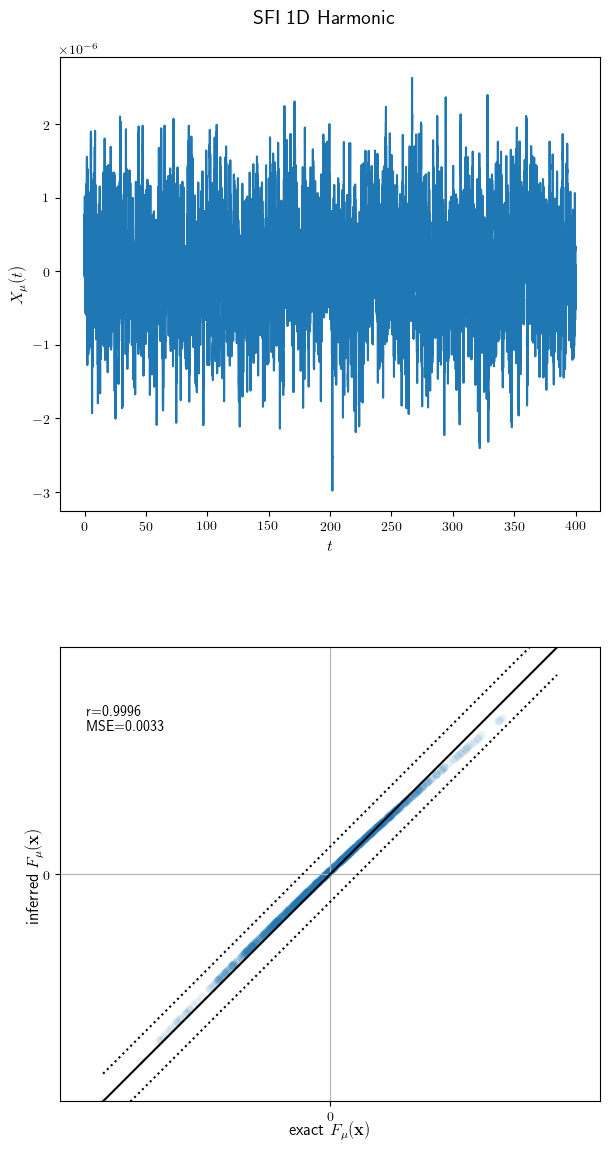

In [7]:
"""

A demo of Stochastic Force Inference, on the example of the double well 1D case.

"""

# Import the package:
from SFI_langevin import OverdampedLangevinProcess
from SFI_data import StochasticTrajectoryData
from SFI_inference import StochasticForceInference
import SFI_plotting_toolkit 
from StochasticForceInference import *

 
################################################################
##### I. Prepare the data (here using a simulated model). ######

### Physical parameters 
R = 1e-7                   # Radius of the Brownian particle [m]
eta = 0.001                # Viscosity of the medium [kg m^-1 s^-1]
T = 300                    # Temperature [K]
k = 10                    # Reference stiffness [fN \mu m ^-1]
gamma = 6 * pi * eta * R  # Reference friction coefficient [kg s^-1]

# Simulation parameters
dim=1
initial_position = np.array([[0. for i in range(dim)]]) 
dt = 0.01
oversampling = 5
prerun = 100
Npts = 40000
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Diffusion parameters: a linear diffusion gradient (multiplicative noise)
diffusion_coeff = kB * T/ gamma 
D = diffusion_coeff *  np.identity(dim) 

#y = np.array([1.,2,1])
#D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# Force field parameters 
a = k *1e-9 / gamma 

force = lambda X : np.array([[-a*x[0]] for x in X ])

# Note: the "for" loop runs over particles/copies of the simulation;
#   it is not used here.


# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(1)
X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun )

# Possibly blur a bit the data to mimic noise from the measurement
# device:
noise_amplitude = 0.0
noise = noise_amplitude * np.random.normal(size=X.data.shape)

# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
xlist = X.data + noise
tlist = X.t
# You can replace "xlist" and "tlist" by your own data!

# Motion blur simulator:
#xlist = (0.5*(X.data[1:] + X.data[:-1]) + noise[:-1])
#tlist = (X.t[:-1])


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

data_exact = StochasticTrajectoryData(X.data,X.t)
S.compare_to_exact(data_exact=data_exact,force_exact=force,D_exact = D)



################################################################
##### III. Plot the results and compare to exact fields.   #####

# Prepare Matplotlib:
import matplotlib.pyplot as plt
fig_size = [6,12]
params = {'axes.labelsize': 12,
          'font.size':   12,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,1

# Plot the trajectory (x and y values):
#plt.subplot(H,W,1)
#data.plot_process(width=0.2)
#plt.gca().axis('off')

# Plot the whole trajectory (all components vs t):
plt.subplot(H,W,1)
plt.plot(data.t,data.X_ito[:,0,:])
plt.ylabel(r"$X_\mu(t)$")
plt.xlabel(r"$t$")


# Plot a slice of the force field - blue is inferred, black is the
# exact one used to generate the data.
#plt.subplot(H,W,2)
#data.plot_field(field=S.F_ansatz,color='b',alpha=0.4,zorder=0,width = 0.2,autoscale=True) 
#data.plot_field(field=X.F,color='k',alpha=1,zorder=-1,width=0.08,autoscale=True) 



plt.subplot(H,W,2)
SFI_plotting_toolkit.comparison_scatter(S.exact_F_Ito,S.ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel(r"exact $F_\mu(\mathbf{x})$",labelpad=-1)
plt.ylabel(r"inferred $F_\mu(\mathbf{x})$",labelpad=0)

#plt.subplot(H,W,5)
#SFI_plotting_toolkit.comparison_scatter(S.exact_D,S.ansatz_D,alpha=0.3,y=0.8,error=S.diffusion_projections_self_consistent_error**0.5)
#plt.xlabel(r"exact $D_{\mu\nu}(\mathbf{x})$",labelpad=-1)
#plt.ylabel(r"inferred $D_{\mu\nu}(\mathbf{x})$",labelpad=0)



# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
#plt.subplot(H,W,5)
#Y = S.simulate_bootstrapped_trajectory(oversampling=10)
#data_bootstrap = StochasticTrajectoryData(Y.data,Y.t)
#data_bootstrap.plot_process(width=0.15,cmap='magma')
#plt.gca().axis('off')

plt.suptitle("SFI 1D Harmonic")
plt.show()


# Example 2 - 2D Harmonic Potential

             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[1.98012653 0.00774553]
 [0.00774553 1.99273736]]
Entropy production: inferred/bootstrapped error 5.439940234664711 24.225603820531067
Drift information: inferred/bootstrapped error 810.9315060666574 40.71686397714484
Drift: squared typical error on projections: 0.008245010822456015
  - due to trajectory length: 0.007398898618580505
  - due to discretization: 0.0008461122038755109
Diffusion: squared typical error on projections: 0.006876771735296986
  - due to trajectory length: 0.0003000150007500375
  - due to discretization: 1.2228933913250267e-17
  - due to drift: 0.006576756734546936
Comparing to exact data...
Mean squared error on force: 0.010062514525953309
Mean squared error on diffusion: 0.00014344862096400454
Exact heat / inferred entropy production: -0.09817570586553503 5.439940234664711


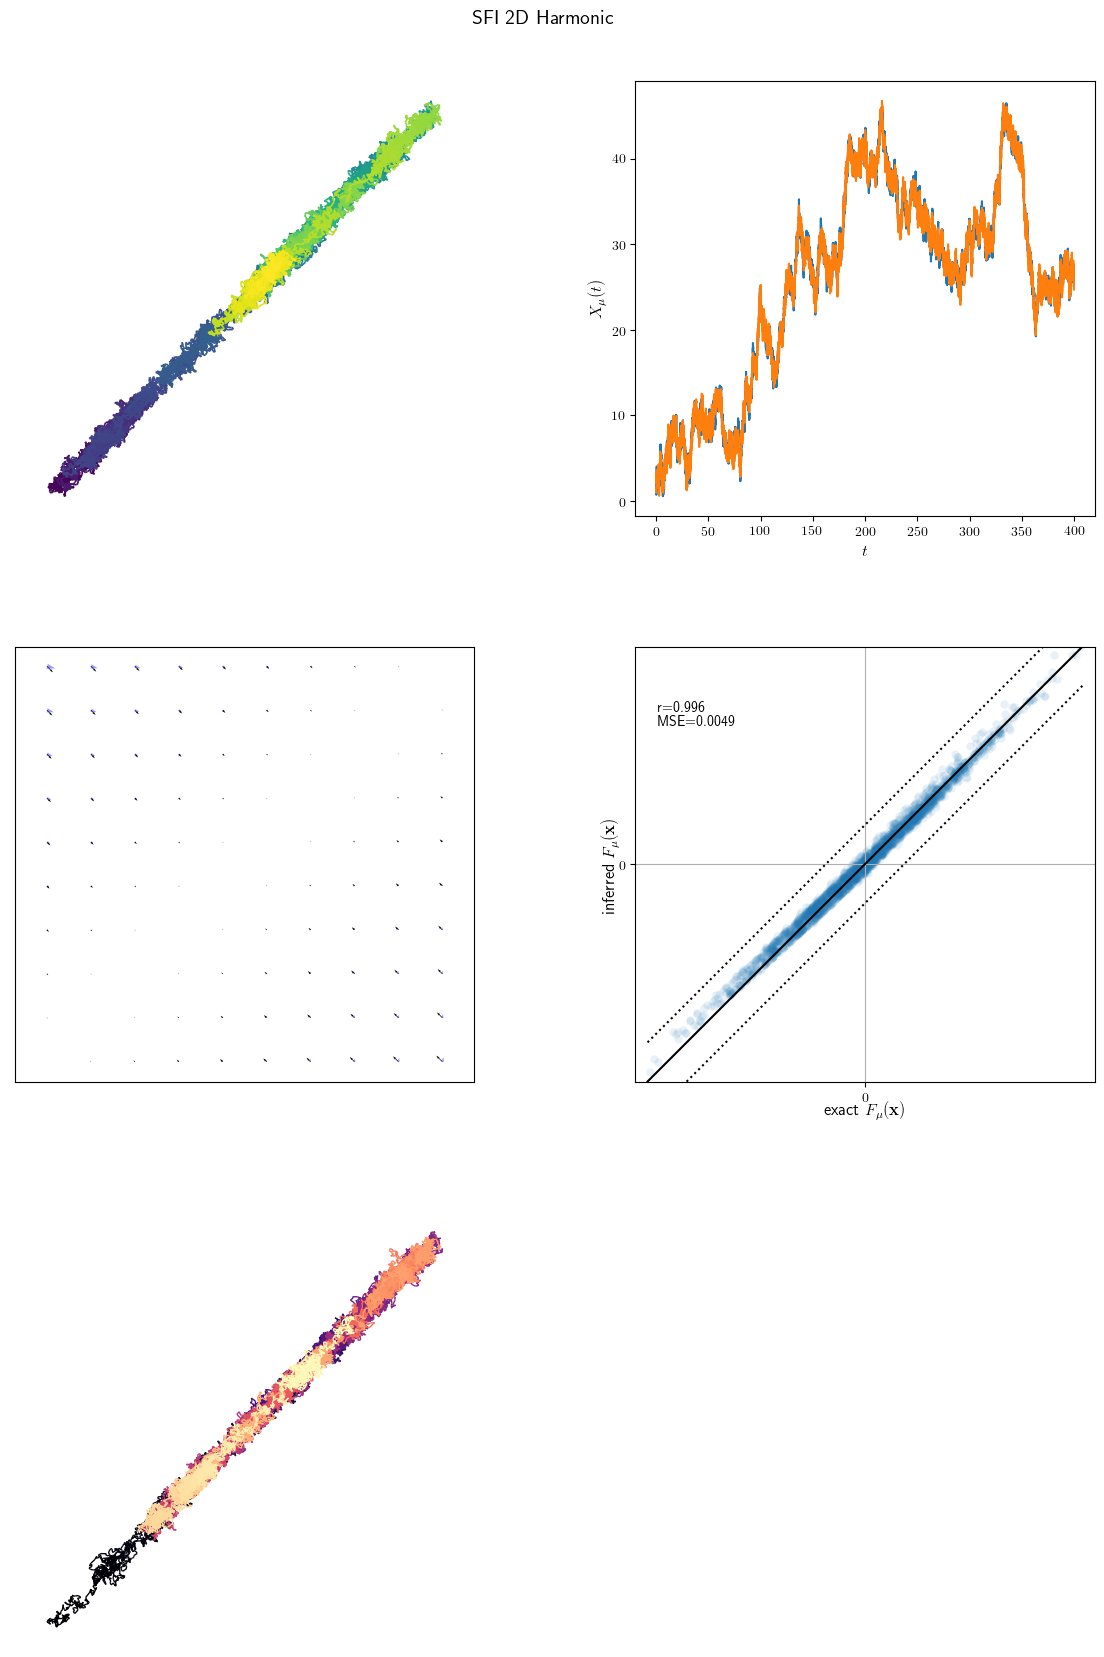

In [8]:
################################################################
##### I. Prepare the data (here using a simulated model). ######

### Physical parameters 
R = 1e-7                   # Radius of the Brownian particle [m]
eta = 0.001                # Viscosity of the medium [kg m^-1 s^-1]
T = 300                    # Temperature [K]
k = 10                    # Reference stiffness [fN m^-1]
M = 10                    # Reference rotational coefficient [N m^-1]
gamma = pi * eta * R  # Reference friction coefficient [kg s^-1]

# Diffusion parameters: a linear diffusion gradient (multiplicative noise)
dim=2
diffusion_coeff = 2
D = diffusion_coeff *  np.identity(dim) 

#y = np.array([1.,2,1])
#D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# Force field parameters 
a = -3
b = -3

force = lambda X : np.array([[a*x[0]-b*x[1], a*x[1]-b*x[0]] for x in X ])

# Note: the "for" loop runs over particles/copies of the simulation;
#   it is not used here.

# Simulation parameters
initial_position = np.array([[0. for i in range(dim)]]) 
dt = 0.01
oversampling = 5
prerun = 100
Npts = 40000
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(1)
X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun )

# Possibly blur a bit the data to mimic noise from the measurement
# device:
noise_amplitude = 0.0
noise = noise_amplitude * np.random.normal(size=X.data.shape)

# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
xlist = X.data + noise
tlist = X.t
# You can replace "xlist" and "tlist" by your own data!

# Motion blur simulator:
#xlist = (0.5*(X.data[1:] + X.data[:-1]) + noise[:-1])
#tlist = (X.t[:-1])


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

data_exact = StochasticTrajectoryData(X.data,X.t)
S.compare_to_exact(data_exact=data_exact,force_exact=force,D_exact = D)



################################################################
##### III. Plot the results and compare to exact fields.   #####

# Prepare Matplotlib:
import matplotlib.pyplot as plt
fig_size = [12,18]
params = {'axes.labelsize': 12,
          'font.size':   12,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 3,2

# Plot the trajectory in (x and y values):
plt.subplot(H,W,1)
data.plot_process(width=0.2)
plt.gca().axis('off')

# Plot the whole trajectory (all components vs t):
plt.subplot(H,W,2)
plt.plot(data.t,data.X_ito[:,0,:])
plt.ylabel(r"$X_\mu(t)$")
plt.xlabel(r"$t$")


# Plot a slice of the force field - blue is inferred, black is the
# exact one used to generate the data.
plt.subplot(H,W,3)
data.plot_field(field=S.F_ansatz,color='b',alpha=0.4,zorder=0,width = 0.2,autoscale=True) 
data.plot_field(field=X.F,color='k',alpha=1,zorder=-1,width=0.08,autoscale=True) 


#Plot the error of force term
plt.subplot(H,W,4)
SFI_plotting_toolkit.comparison_scatter(S.exact_F_Ito,S.ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel(r"exact $F_\mu(\mathbf{x})$",labelpad=-1)
plt.ylabel(r"inferred $F_\mu(\mathbf{x})$",labelpad=0)

#Plot the error of the diffusion term
#plt.subplot(H,W,5)
#SFI_plotting_toolkit.comparison_scatter(S.exact_D,S.ansatz_D,alpha=0.3,y=0.8,error=S.diffusion_projections_self_consistent_error**0.5)
#plt.xlabel(r"exact $D_{\mu\nu}(\mathbf{x})$",labelpad=-1)
#plt.ylabel(r"inferred $D_{\mu\nu}(\mathbf{x})$",labelpad=0)


# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
plt.subplot(H,W,5)
Y = S.simulate_bootstrapped_trajectory(oversampling=10)
data_bootstrap = StochasticTrajectoryData(Y.data,Y.t)
data_bootstrap.plot_process(width=0.15,cmap='magma')
plt.gca().axis('off')

plt.suptitle("SFI 2D Harmonic")
plt.show()

# Example 3 - 2D DoubleWell

             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[1.00439533 0.01506303]
 [0.01506303 0.97816759]]
Entropy production: inferred/bootstrapped error 8.487126190164496 40.211618375543274
Drift information: inferred/bootstrapped error 126.5891743339207 18.79303989959691
Drift: squared typical error on projections: 0.08969218880201847
  - due to trajectory length: 0.07899569653264112
  - due to discretization: 0.010696492269377352
Diffusion: squared typical error on projections: 0.019042356655350742
  - due to trajectory length: 0.0030015007503751876
  - due to discretization: 7.415341569444689e-13
  - due to drift: 0.01604085590423402
Comparing to exact data...
Mean squared error on force: 0.07305560182240116
Mean squared error on diffusion: 0.0022379411451160535
Exact heat / inferred entropy production: -0.446161711411168 8.487126190164496


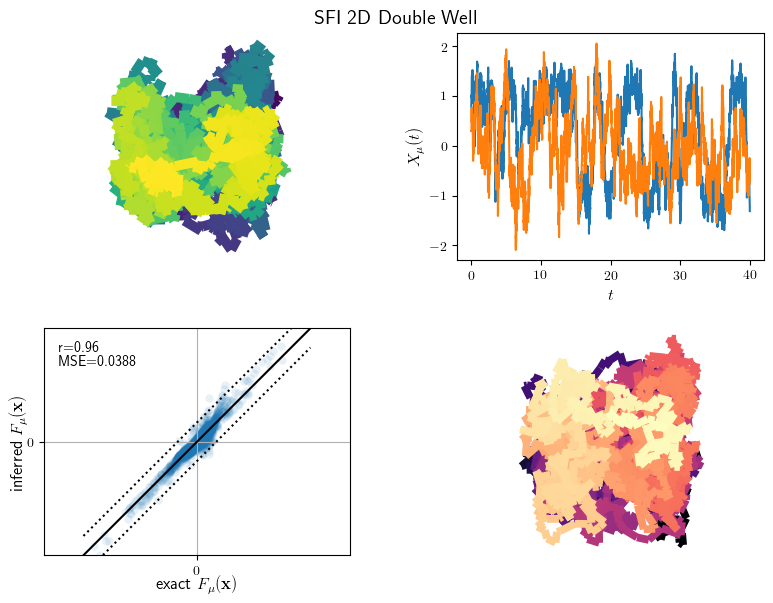

In [9]:
################################################################
##### I. Prepare the data (here using a simulated model). ######


# Diffusion parameters: a linear diffusion gradient (multiplicative noise)
dim=2
diffusion_coeff = 1.
D = diffusion_coeff *  np.identity(dim) 

#y = np.array([1.,2,1])
#D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# Force field parameters 
#a,b,c = 3., 3., 3.

force = lambda X : np.array([[-4*(x[0]**2-1)*x[0], -2*x[1]] for x in X ])

# Note: the "for" loop runs over particles/copies of the simulation;
#   it is not used here.

# Simulation parameters
initial_position = np.array([[0.1 for i in range(dim)]]) 
dt = 0.01
oversampling = 4
prerun = 100
Npts = 4000
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(1)
X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun )

# Possibly blur a bit the data to mimic noise from the measurement
# device:
noise_amplitude = 0.0
noise = noise_amplitude * np.random.normal(size=X.data.shape)

# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
xlist = X.data + noise
tlist = X.t
# You can replace "xlist" and "tlist" by your own data!

# Motion blur simulator:
#xlist = (0.5*(X.data[1:] + X.data[:-1]) + noise[:-1])
#tlist = (X.t[:-1])


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 3} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

data_exact = StochasticTrajectoryData(X.data,X.t)
S.compare_to_exact(data_exact=data_exact,force_exact=force,D_exact = D)



################################################################
##### III. Plot the results and compare to exact fields.   #####

# Prepare Matplotlib:
import matplotlib.pyplot as plt
fig_size = [8,6]
params = {'axes.labelsize': 12,
          'font.size':   12,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,2

# Plot the trajectory (x and y values):
plt.subplot(H,W,1)
data.plot_process(width=0.2)
plt.gca().axis('off')

# Plot the whole trajectory (all components vs t):
plt.subplot(H,W,2)
plt.plot(data.t,data.X_ito[:,0,:])
plt.ylabel(r"$X_\mu(t)$")
plt.xlabel(r"$t$")


# Plot a slice of the force field - blue is inferred, black is the
# exact one used to generate the data.
#plt.subplot(H,W,3)
#data.plot_field(field=S.F_ansatz,color='b',alpha=0.4,zorder=0,width = 0.2,autoscale=True) 
#data.plot_field(field=X.F,color='k',alpha=1,zorder=-1,width=0.08,autoscale=True) 



plt.subplot(H,W,3)
SFI_plotting_toolkit.comparison_scatter(S.exact_F_Ito,S.ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel(r"exact $F_\mu(\mathbf{x})$",labelpad=-1)
plt.ylabel(r"inferred $F_\mu(\mathbf{x})$",labelpad=0)

#plt.subplot(H,W,5)
#SFI_plotting_toolkit.comparison_scatter(S.exact_D,S.ansatz_D,alpha=0.3,y=0.8,error=S.diffusion_projections_self_consistent_error**0.5)
#plt.xlabel(r"exact $D_{\mu\nu}(\mathbf{x})$",labelpad=-1)
#plt.ylabel(r"inferred $D_{\mu\nu}(\mathbf{x})$",labelpad=0)



# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
plt.subplot(H,W,4)
Y = S.simulate_bootstrapped_trajectory(oversampling=10)
data_bootstrap = StochasticTrajectoryData(Y.data,Y.t)
data_bootstrap.plot_process(width=0.15,cmap='magma')
plt.gca().axis('off')

plt.suptitle("SFI 2D Double Well")
plt.show()


# Example 4 - Lorenz

/Users/zhangqiqi/Desktop/lcp project/SFI/SFI_inference.py:298: RuntimeWarning: invalid value encountered in double_scalars
  self.Sdot_error = (2 * self.Sdot/self.data.tauN  + self.Sdot_bias**2 )**0.5


             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[ 7.44913684  1.50928084  6.38346068]
 [ 1.50928084 24.08399461  1.10951645]
 [ 6.38346068  1.10951645 13.83903887]]
Entropy production: inferred/bootstrapped error -25979.750834167917 nan
Drift information: inferred/bootstrapped error 10012.341844755232 142.301383301465
Drift: squared typical error on projections: 0.00574441342730511
  - due to trajectory length: 0.001498151005287285
  - due to discretization: 0.004246262422017825
Diffusion: squared typical error on projections: 16.049539669979424
  - due to trajectory length: 0.0036007201440288058
  - due to discretization: 2.942672122083116e-06
  - due to drift: 16.045936007163274
Comparing to exact data...
Mean squared error on force: 0.003133500135417462
Mean squared error on diffusion: 0.8223645381300837
Exact heat / inferred entropy production: -176163.57865952235 -25979.750834167917


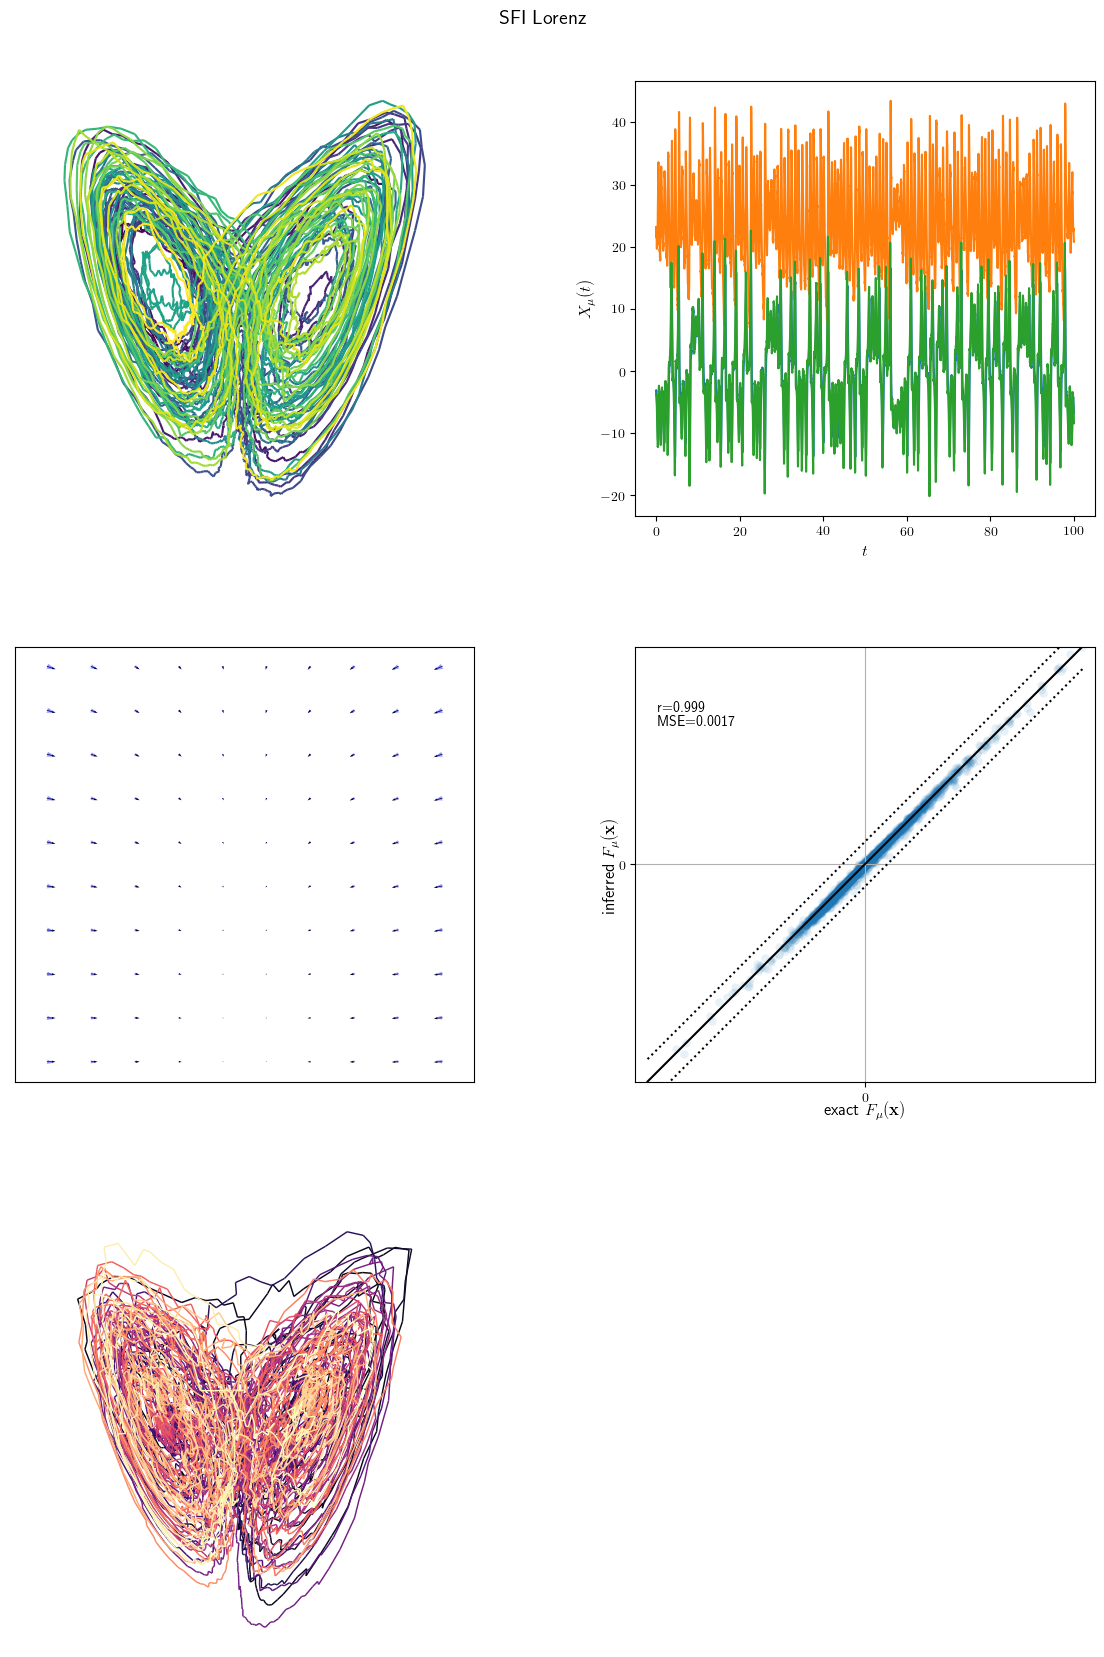

In [10]:
################################################################
##### I. Prepare the data (here using a simulated model). ######


# Diffusion parameters: a linear diffusion gradient (multiplicative noise)
dim=3
diffusion_coeff = 1.
D = diffusion_coeff *  np.identity(dim) 

y = np.array([1.,2,1])
D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# Force field parameters (stochastic Lorenz process)
r,b,s = 27.,8/4,11.

force = lambda X : np.array([[ s*(x[2]-x[0]),
                               x[0]*x[2]-b*x[1],
                               r*x[0] - x[2] - x[1]*x[0]] for x in X ])

# Note: the "for" loop runs over particles/copies of the simulation;
#   it is not used here.

# Simulation parameters 
initial_position = np.array([[0.1 for i in range(dim)]]) 
dt = 0.01
oversampling = 4
prerun = 100
Npts = 10000
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(1)
X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun )

# Possibly blur a bit the data to mimic noise from the measurement
# device:
noise_amplitude = 0.0
noise = noise_amplitude * np.random.normal(size=X.data.shape)

# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
xlist = X.data + noise
tlist = X.t
# You can replace "xlist" and "tlist" by your own data!

# Motion blur simulator:
#xlist = (0.5*(X.data[1:] + X.data[:-1]) + noise[:-1])
#tlist = (X.t[:-1])


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

data_exact = StochasticTrajectoryData(X.data,X.t)
S.compare_to_exact(data_exact=data_exact,force_exact=force,D_exact = D)



################################################################
##### III. Plot the results and compare to exact fields.   #####

# Prepare Matplotlib:
import matplotlib.pyplot as plt
fig_size = [12,18]
params = {'axes.labelsize': 12,
          'font.size':   12,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 3,2

# Plot the trajectory (x and y values):
plt.subplot(H,W,1)
data.plot_process(width=0.2)
plt.gca().axis('off')

# Plot the whole trajectory (all components vs t):
plt.subplot(H,W,2)
plt.plot(data.t,data.X_ito[:,0,:])
plt.ylabel(r"$X_\mu(t)$")
plt.xlabel(r"$t$")


# Plot a slice of the force field - blue is inferred, black is the
# exact one used to generate the data.
plt.subplot(H,W,3)
data.plot_field(field=S.F_ansatz,color='b',alpha=0.4,zorder=0,width = 0.2,autoscale=True) 
data.plot_field(field=X.F,color='k',alpha=1,zorder=-1,width=0.08,autoscale=True) 



plt.subplot(H,W,4)
SFI_plotting_toolkit.comparison_scatter(S.exact_F_Ito,S.ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel(r"exact $F_\mu(\mathbf{x})$",labelpad=-1)
plt.ylabel(r"inferred $F_\mu(\mathbf{x})$",labelpad=0)

#plt.subplot(H,W,5)
#SFI_plotting_toolkit.comparison_scatter(S.exact_D,S.ansatz_D,alpha=0.3,y=0.8,error=S.diffusion_projections_self_consistent_error**0.5)
#plt.xlabel(r"exact $D_{\mu\nu}(\mathbf{x})$",labelpad=-1)
#plt.ylabel(r"inferred $D_{\mu\nu}(\mathbf{x})$",labelpad=0)



# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
plt.subplot(H,W,5)
Y = S.simulate_bootstrapped_trajectory(oversampling=10)
data_bootstrap = StochasticTrajectoryData(Y.data,Y.t)
data_bootstrap.plot_process(width=0.15,cmap='magma')
plt.gca().axis('off')

plt.suptitle("SFI Lorenz")
plt.show()

# Example 5 - Active Brownian Particles

/Users/zhangqiqi/Desktop/lcp project/SFI/SFI_bases.py:171: RuntimeWarning: divide by zero encountered in true_divide
  f_Rij = np.nan_to_num(np.array([ f(Rij)/Rij for f in kernels ]))


             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[ 0.97573239 -0.0071135  -0.00260006]
 [-0.0071135   0.98863761 -0.00124792]
 [-0.00260006 -0.00124792  0.10025814]]
Entropy production: inferred/bootstrapped error 816.5678854388641 98.65665598872549
Drift information: inferred/bootstrapped error 691.4832890990303 43.46511909793945
Drift: squared typical error on projections: 0.03434845383697987
  - due to trajectory length: 0.03253874729108266
  - due to discretization: 0.0018097065458972106
Diffusion: squared typical error on projections: 0.012650449155869171
  - due to trajectory length: 0.00036072144288577156
  - due to discretization: 0.0
  - due to drift: 0.0122897277129834
Comparing to exact data...
Mean squared error on force: 0.03974735126763139
Mean squared error on diffusion: 0.0003498216156288003
Exact heat / inferred entropy production: 1062.0839481284015 816.5678854388641


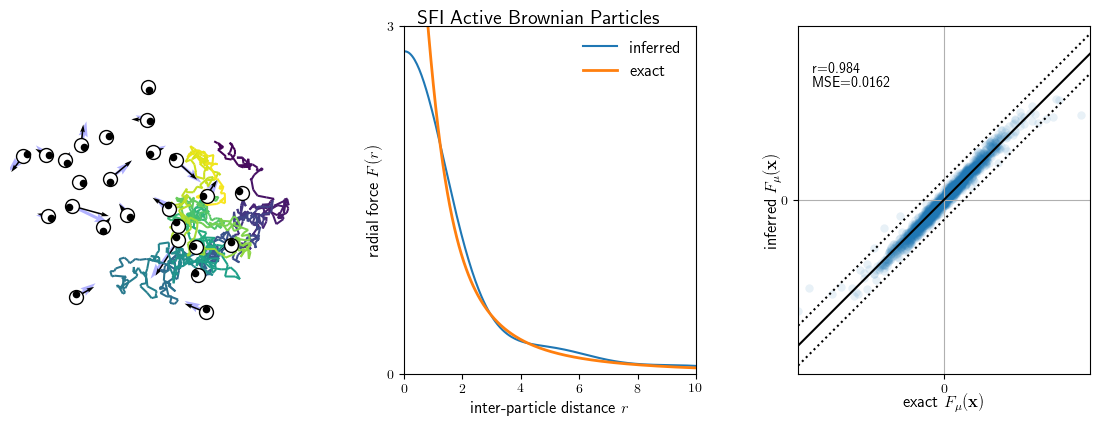

In [11]:
################################################################
##### I. Prepare the data (here using a simulated model). ######


np.random.seed(1)

omega = 0.2
Factive = 1.
D = 1.
Dangular = 0.1
W = 5

N = 1000
dt = 0.1
tau = dt * (N-1)
tlist = np.linspace(0.,tau,N)

oversampling = 10
prerun = 2**7

epsilon = 5.
R0 = 1.

def pair(R0,epsilon):
    def pair_interaction(rij):
        return epsilon * 1/((rij/R0)**2+1)
    return pair_interaction


from SFI_langevin import ParticlesOverdampedLangevinProcess
class ActiveBrownianParticles(ParticlesOverdampedLangevinProcess):
    def __init__(self,omega,pair_interaction,Factive,D,Dangular,R0,W,tlist,prerun=0,oversampling=1):
        # Initial position: 2D square crystal with 2*R0 spacing
        initial_position = np.array([ [x,y, 2*np.pi*np.random.random()] for x in np.linspace(-W*R0,W*R0,W) for y in np.linspace(-W*R0,W*R0,W) ])
        
        # Harmonic trapping:
        harmonic_active = lambda X : np.array([ - omega * X[0] + Factive * np.cos(X[2]), - omega * X[1] + Factive * np.sin(X[2]), 0. ])

        def pair(Xi,Xj):
            dx,dy = Xi[0]-Xj[0],Xi[1]-Xj[1]
            rij = (dx**2 + dy**2)**0.5
            return pair_interaction(rij) * np.array([dx,dy,0]) /rij

        Dmatrix = np.array([[ D,0,0],
                            [ 0,D,0],
                            [ 0,0,Dangular]])
        
        ParticlesOverdampedLangevinProcess.__init__( self, harmonic_active, pair, Dmatrix, tlist, initial_position, oversampling = oversampling, prerun = prerun)



pair_interaction = pair(R0,epsilon)
X = ActiveBrownianParticles(omega,pair_interaction,Factive,D,Dangular,R0,W,tlist,prerun=prerun,oversampling=oversampling)

# Possibly blur a bit the data to mimic noise from the measurement
# device:
noise_amplitude = 0.0
noise = noise_amplitude * np.random.normal(size=X.data.shape)

# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
xlist = X.data + noise

freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   

center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######

S = StochasticForceInference(data)  


# Choose the radial kernels with which to fit the pair interaction -
# here Npts Gaussians
r0 = 2.
Rmax = 10
Npts = 5
sigma=2.
def Gaussian_kernel(sigma,r0):
    # Factory to limit the scope of k
    return lambda r : np.exp(-(r-r0)**2/(2*sigma))
kernels = [ Gaussian_kernel(sigma,r0) for r0 in np.linspace(0,Rmax,Npts) ]

S.compute_drift(
    basis={ 'type' : 'self_propelled_particles', 'order' : 1, 'kernels' : kernels },\
    diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
    #diffusion_mode = 'constant',   
    #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
    #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
    #mode='Ito'  # Use only for noise-free data.
) 

S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 0}
) 


S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

data_exact = StochasticTrajectoryData(X.data,X.t)
S.compare_to_exact(data_exact=data_exact,force_exact=X.F,D_exact = X.D)



################################################################
##### III. Plot the results and compare to exact fields.   #####

# Prepare Matplotlib:
import matplotlib.pyplot as plt
fig_size = [12,4]
params = {'axes.labelsize': 12,
          'font.size':   12,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 1,3


 # Plot the trajectory (x and y values):
plt.subplot(H,W,1)
data.plot_process(width=0.2)
plt.gca().axis('off')
data.plot_particles(0,1,X = X.data[-1],t=-1,colored=False,active=True,u=-0.35)

Fscale = 2
# The exact forces at time t:
data.plot_particles_field(X.F,X=X.data[-1],alpha=1,zorder=0,color='k',width=0.15,scale = Fscale)
# The inferred forces:
data.plot_particles_field(S.F_ansatz,X=X.data[-1],t=-1,zorder=-1,color='b',alpha=0.3,width=0.3,scale = Fscale)

# Plot the whole trajectory (all components vs t):
#plt.subplot(H,W,2)

#plt.plot(data.t,data.X_ito[:,0,0],label=r"$x(t)$")
#plt.plot(data.t,data.X_ito[:,0,1],label=r"$y(t)$")
#plt.plot(data.t,data.X_ito[:,0,2],label=r"$\theta(t)$")
#plt.ylabel(r"one particle's coordinates")
#plt.legend()
#plt.xlabel(r"$t$")

plt.subplot(H,W,2)

Nfuncs = len(kernels)
# Select the fitting coefficients on the radial kernels, and take the
# isotropic part:
Fmunu = S.phi_coefficients[:2,5:].reshape(2,Nfuncs,2)
Fradial = np.einsum('mkm->k',Fmunu)/2.
F = lambda r : sum( -kernels[i](r) * Fradial[i] for i in range(Nfuncs) )

rmax = 20
rvals = np.linspace(0,rmax,500)
plt.plot(rvals,F(rvals),label='inferred')
plt.plot(rvals,pair_interaction(rvals),label='exact',lw=2)

plt.ylim(0.,3.)

plt.yticks([0,3])
plt.xlim(0,10)
#plt.grid()

plt.xlabel(r"inter-particle distance $r$",fontsize=12)
plt.ylabel(r"radial force $F(r)$",fontsize=12)

plt.legend(loc=0,frameon=False,fontsize=12)

plt.subplot(H,W,3)
SFI_plotting_toolkit.comparison_scatter(S.exact_F_Ito,S.ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel(r"exact $F_\mu(\mathbf{x})$",labelpad=-1)
plt.ylabel(r"inferred $F_\mu(\mathbf{x})$",labelpad=0)

#plt.subplot(H,W,5)
#SFI_plotting_toolkit.comparison_scatter(S.exact_D,S.ansatz_D,alpha=0.3,y=0.8,error=S.diffusion_projections_self_consistent_error**0.5)
#plt.xlabel(r"exact $D_{\mu\nu}(\mathbf{x})$",labelpad=-1)
#plt.ylabel(r"inferred $D_{\mu\nu}(\mathbf{x})$",labelpad=0)



# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
#plt.subplot(H,W,6)
#Y = S.simulate_bootstrapped_trajectory(oversampling=10)
#data_bootstrap = StochasticTrajectoryData(Y.data,Y.t)
#data_bootstrap.plot_process(width=0.15,cmap='magma')
#data_bootstrap.plot_particles(0,1,X = X.data[-1],t=-1,colored=False,active=True,u=-0.35)
#plt.gca().axis('off')

plt.suptitle("SFI Active Brownian Particles")
plt.show()